In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
datafile = 'MTA_Congestion_Relief_Zone_Vehicle_Entries__Beginning_2025_20250404.csv'
mta = pd.read_csv(datafile)
mta.head()

Toll Date               Toll Hour    Toll 10 Minute Block  Minute of Hour  \
0  03/29/2025  03/29/2025 11:00:00 PM  03/29/2025 11:50:00 PM              50   
1  03/29/2025  03/29/2025 11:00:00 PM  03/29/2025 11:50:00 PM              50   
2  03/29/2025  03/29/2025 11:00:00 PM  03/29/2025 11:50:00 PM              50   
3  03/29/2025  03/29/2025 11:00:00 PM  03/29/2025 11:50:00 PM              50   
4  03/29/2025  03/29/2025 11:00:00 PM  03/29/2025 11:50:00 PM              50   

   Hour of Day  Day of Week Int Day of Week   Toll Week Time Period  \
0           23                7    Saturday  03/23/2025   Overnight   
1           23                7    Saturday  03/23/2025   Overnight   
2           23                7    Saturday  03/23/2025   Overnight   
3           23                7    Saturday  03/23/2025   Overnight   
4           23                7    Saturday  03/23/2025   Overnight   

                Vehicle Class               Detection Group  \
0  1 - Cars, Pickups and Vans               Brooklyn Bridge   
1                TLC Taxi/FHV  West Side Highway at 60th St   
2                TLC Taxi/FHV                  West 60th St   
3                TLC Taxi/FHV             Queensboro Bridge   
4                TLC Taxi/FHV         Queens Midtown Tunnel   

    Detection Region  CRZ Entries  Excluded Roadway Entries  
0           Brooklyn          103                        99  
1  West Side Highway           97                         2  
2       West 60th St          197                         0  
3             Queens           77                         0  
4             Queens          137                         0

In [40]:
mta_subset = mta[['Toll 10 Minute Block', 'Vehicle Class', 'Detection Region', 'CRZ Entries']]
crz_blockregion = mta_subset.groupby(
    ['Toll 10 Minute Block', 'Detection Region', 'Vehicle Class']
)['CRZ Entries'].sum().reset_index()
crz_blockregion['Toll 10 Minute Block'] = pd.to_datetime(crz_blockregion['Toll 10 Minute Block'])

print(crz_blockregion[:10])

  Toll 10 Minute Block Detection Region               Vehicle Class  \
0           2025-01-05         Brooklyn  1 - Cars, Pickups and Vans   
1           2025-01-05         Brooklyn      2 - Single-Unit Trucks   
2           2025-01-05         Brooklyn       3 - Multi-Unit Trucks   
3           2025-01-05         Brooklyn                   4 - Buses   
4           2025-01-05         Brooklyn             5 - Motorcycles   
5           2025-01-05         Brooklyn                TLC Taxi/FHV   
6           2025-01-05     East 60th St  1 - Cars, Pickups and Vans   
7           2025-01-05     East 60th St      2 - Single-Unit Trucks   
8           2025-01-05     East 60th St       3 - Multi-Unit Trucks   
9           2025-01-05     East 60th St                   4 - Buses   

   CRZ Entries  
0          349  
1            4  
2            1  
3            0  
4            0  
5          332  
6          208  
7            3  
8            2  
9            3  


In [31]:
start_date = pd.to_datetime('2025-01-13')
end_date = start_date + pd.Timedelta(days=21)
week_mask = (crz_blockregion['Toll 10 Minute Block'] >= start_date) & (crz_blockregion['Toll 10 Minute Block'] < end_date)
week_data = crz_blockregion.loc[week_mask].copy()

In [37]:
regions = week_data['Detection Region'].unique()
print(regions)

['Brooklyn' 'East 60th St' 'FDR Drive' 'New Jersey' 'Queens'
 'West 60th St' 'West Side Highway']


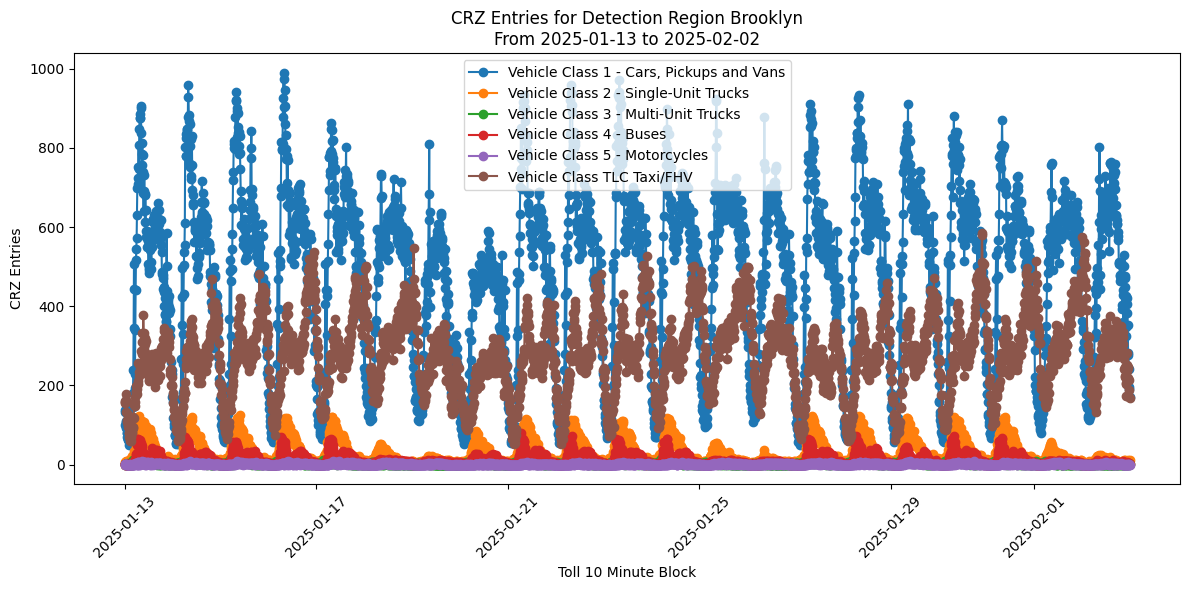

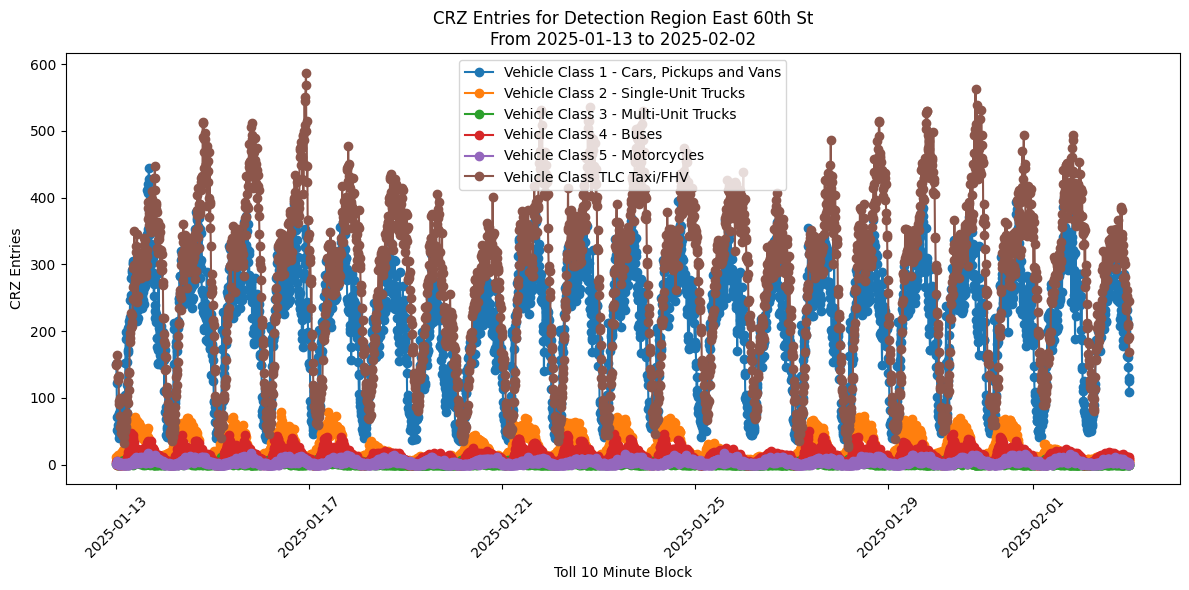

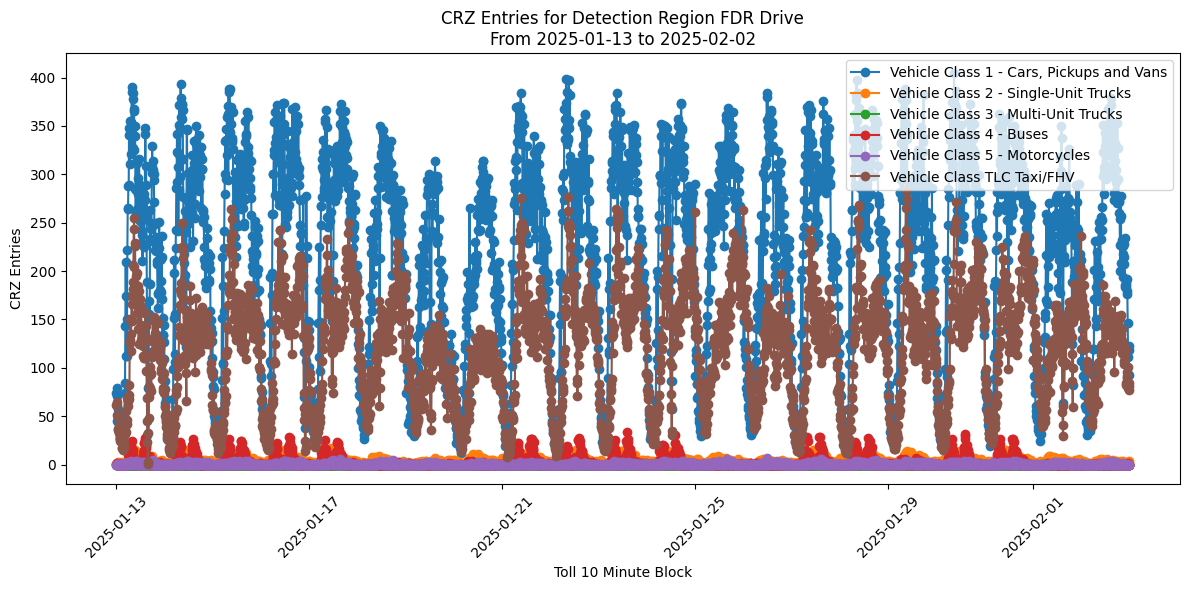

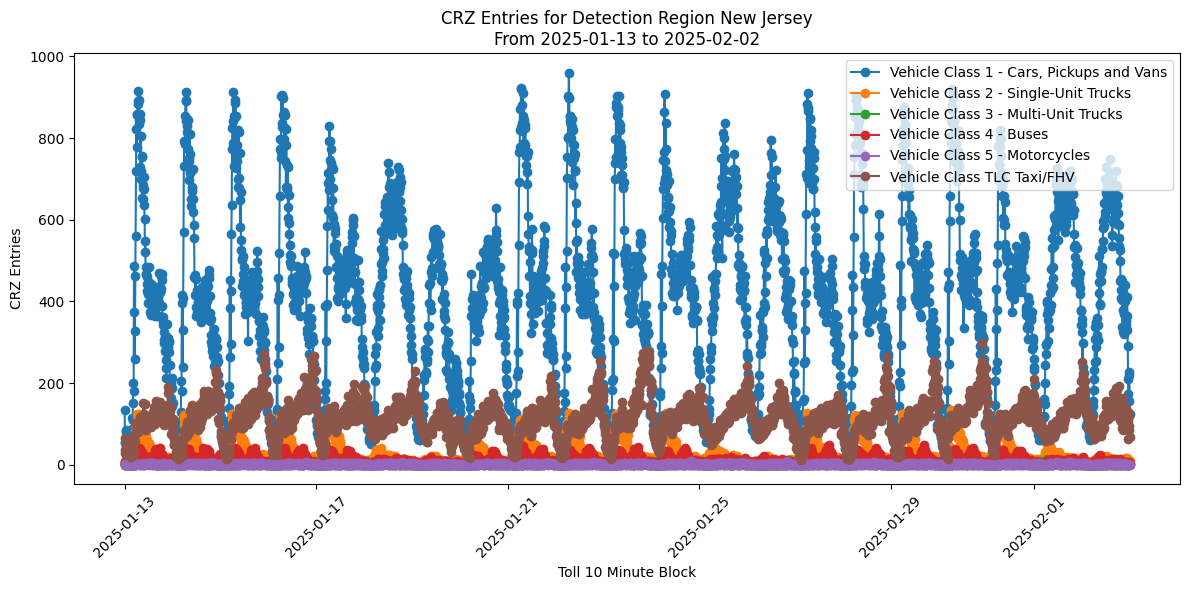

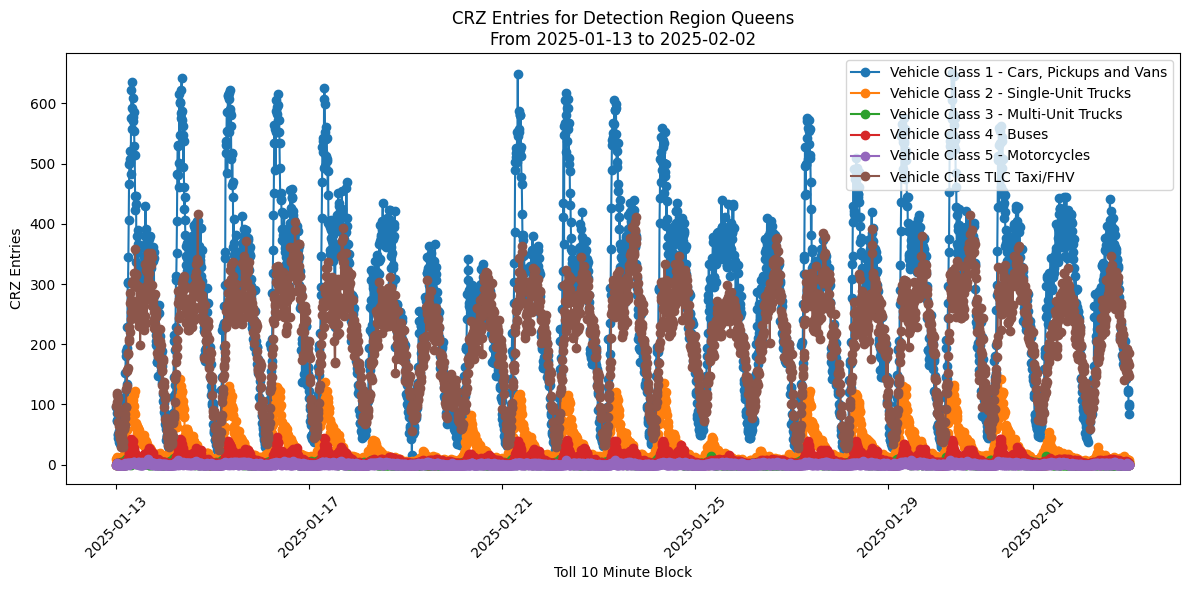

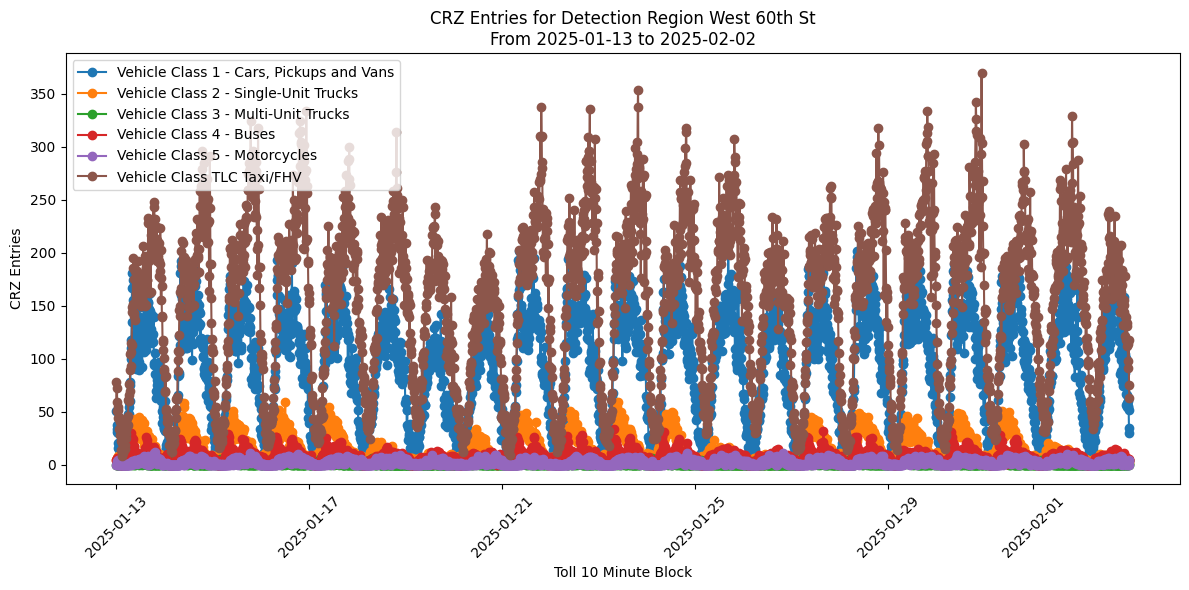

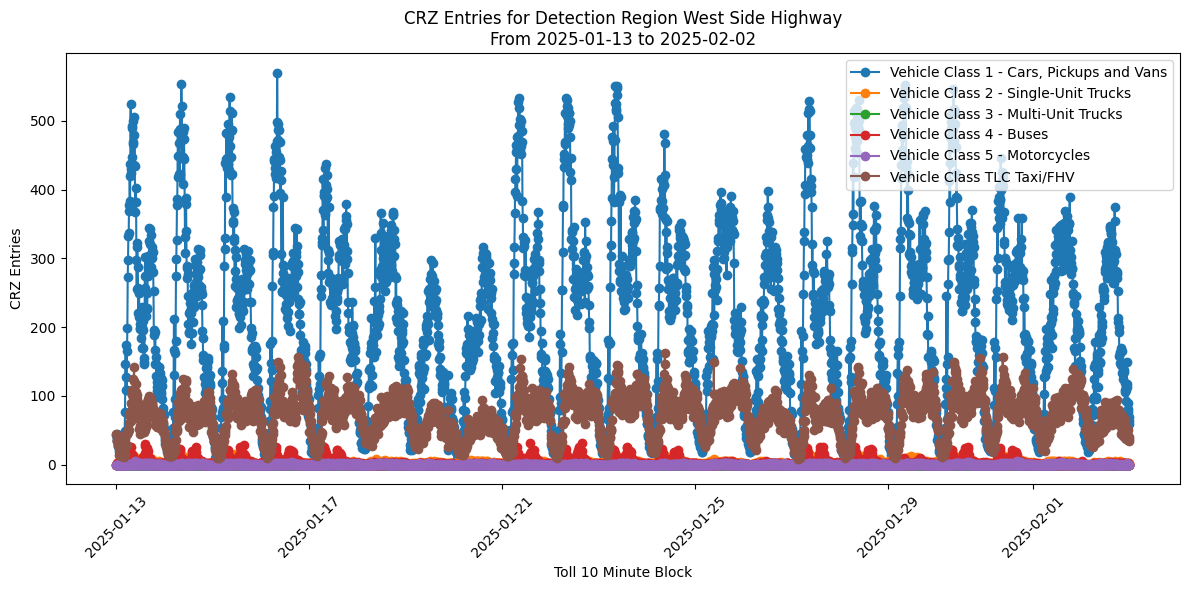

In [34]:
for region in regions:
    region_data = week_data[week_data['Detection Region'] == region]
    vehicle_classes = region_data['Vehicle Class'].unique()
    
    plt.figure(figsize=(12, 6))
    for vc in vehicle_classes:
        vc_data = region_data[region_data['Vehicle Class'] == vc]
        plt.plot(vc_data['Toll 10 Minute Block'], vc_data['CRZ Entries'],
                 marker='o', linestyle='-', label=f'Vehicle Class {vc}')
    
    plt.title(f'CRZ Entries for Detection Region {region}\nFrom {start_date.date()} to {(end_date - pd.Timedelta(seconds=1)).date()}')
    plt.xlabel('Toll 10 Minute Block')
    plt.ylabel('CRZ Entries')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [44]:
crz_blockregion['Toll 10 Minute Block'] = pd.to_datetime(crz_blockregion['Toll 10 Minute Block'])
df = crz_blockregion.copy()

df['minute_of_day'] = df['Toll 10 Minute Block'].dt.hour * 60 + df['Toll 10 Minute Block'].dt.minute
df['tod_sin'] = np.sin(2 * np.pi * df['minute_of_day'] / 1440)
df['tod_cos'] = np.cos(2 * np.pi * df['minute_of_day'] / 1440)

df['day_of_week'] = df['Toll 10 Minute Block'].dt.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

features = ['tod_sin', 'tod_cos', 'dow_sin', 'dow_cos']


In [46]:
all_future_preds = []

for region in df['Detection Region'].unique():
    df_region = df[df['Detection Region'] == region].copy()
    for vclass in df_region['Vehicle Class'].unique():
        df_group = df_region[df_region['Vehicle Class'] == vclass].copy()
        df_group.dropna(inplace=True)
        if df_group.empty:
            continue
        
        # Prepare training data.
        X = df_group[features]
        y = df_group['CRZ Entries']
        
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Build a simple neural network.
        model = Sequential([
            Input(shape=(X_scaled.shape[1],)),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)  # Regression output
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_scaled, y, epochs=50, verbose=0)
        
        # Determine the last timestamp in the historical data.
        last_time = df_group['Toll 10 Minute Block'].max()
        
        # Generate future timestamps at 10-minute intervals for one month ahead.
        future_times = pd.date_range(
            start=last_time + pd.Timedelta(minutes=10),
            end=last_time + pd.DateOffset(months=1),
            freq='10min'
        )
        
        # Build a DataFrame for the future timestamps and compute seasonal features.
        future_df = pd.DataFrame({'Toll 10 Minute Block': future_times})
        future_df['minute_of_day'] = future_df['Toll 10 Minute Block'].dt.hour * 60 + future_df['Toll 10 Minute Block'].dt.minute
        future_df['tod_sin'] = np.sin(2 * np.pi * future_df['minute_of_day'] / 1440)
        future_df['tod_cos'] = np.cos(2 * np.pi * future_df['minute_of_day'] / 1440)
        future_df['day_of_week'] = future_df['Toll 10 Minute Block'].dt.dayofweek
        future_df['dow_sin'] = np.sin(2 * np.pi * future_df['day_of_week'] / 7)
        future_df['dow_cos'] = np.cos(2 * np.pi * future_df['day_of_week'] / 7)
        
        X_future = future_df[features]
        X_future_scaled = scaler.transform(X_future)
        future_preds = model.predict(X_future_scaled).flatten()
        
        # Add group labels to the forecast DataFrame.
        future_df['Detection Region'] = region
        future_df['Vehicle Class'] = vclass
        future_df['Predicted CRZ Entries'] = future_preds
        
        all_future_preds.append(future_df[['Toll 10 Minute Block', 'Detection Region', 'Vehicle Class', 'Predicted CRZ Entries']])

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
140/140 ━━━━━━━━

In [47]:
all_future_preds_df = pd.concat(all_future_preds, ignore_index=True)
all_future_preds_df.to_csv('future_predictions_by_region_vehicle.csv', index=False)
print("Predictions saved to future_predictions_by_region_vehicle.csv")

Predictions saved to future_predictions_by_region_vehicle.csv


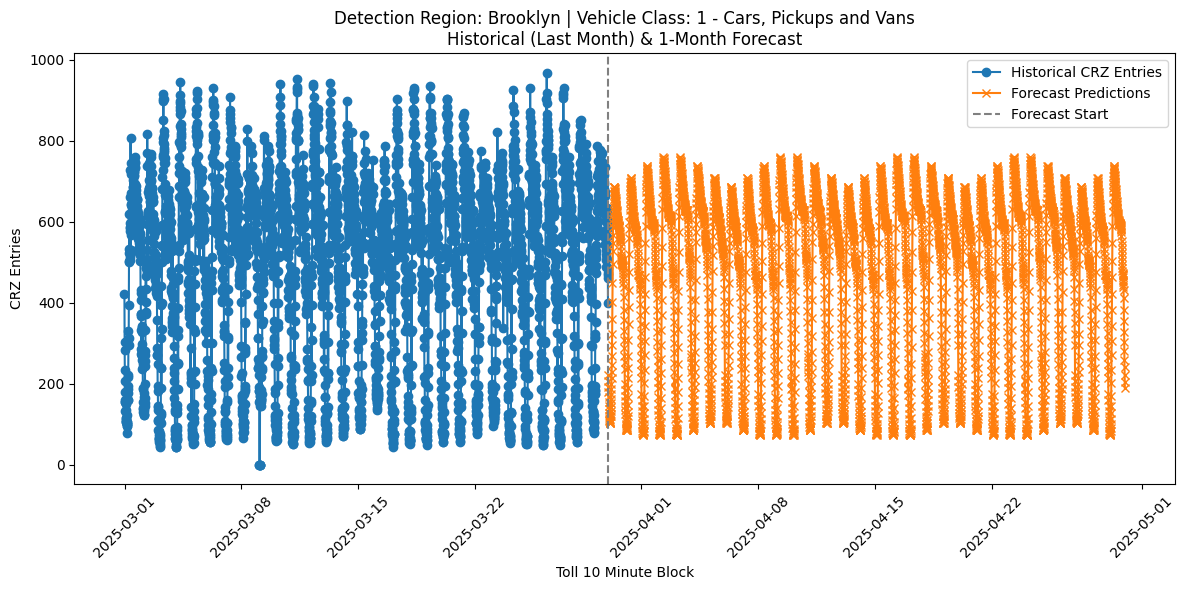

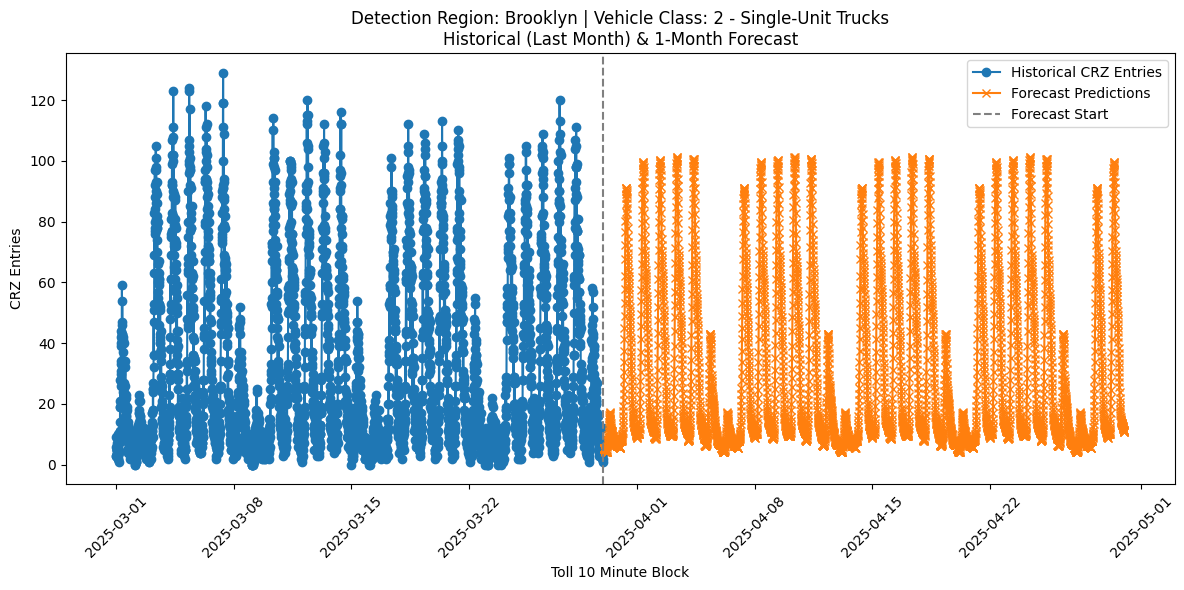

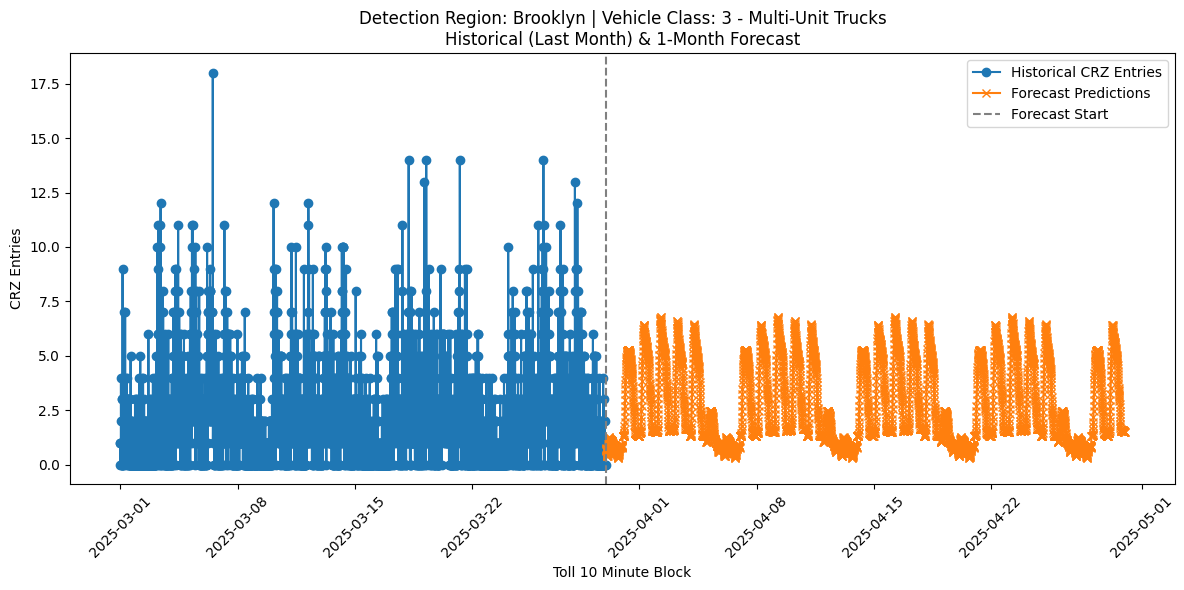

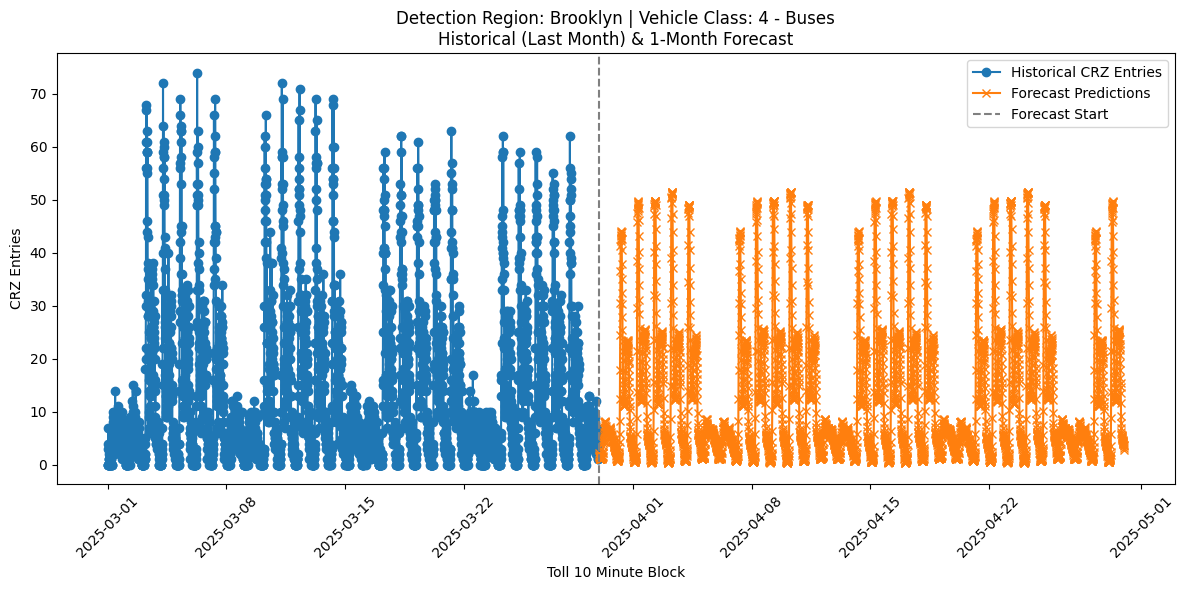

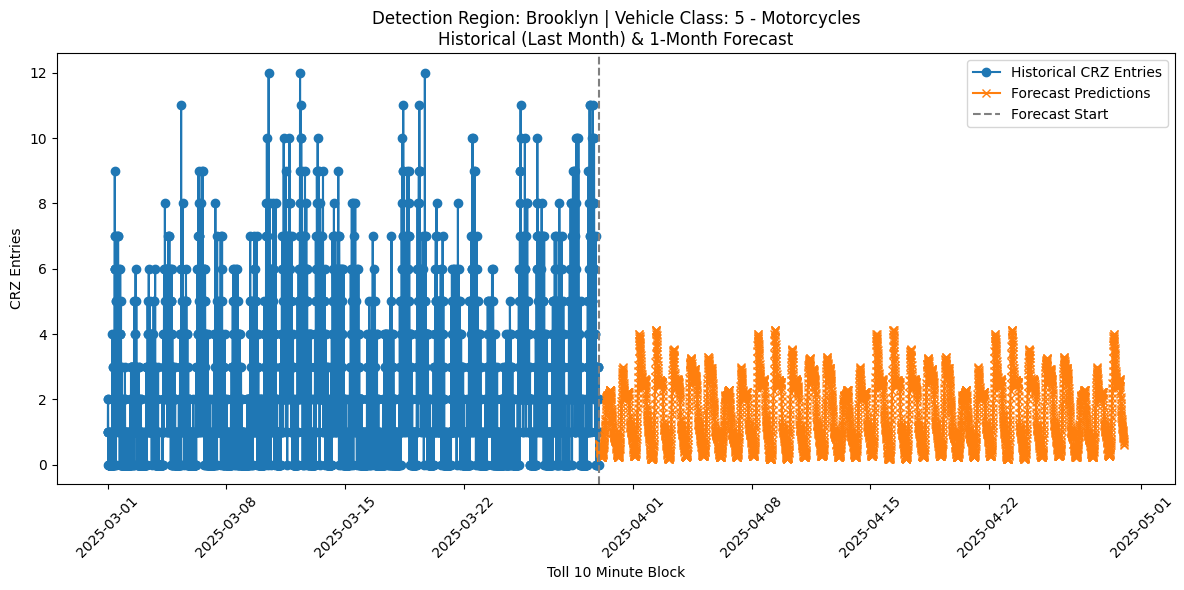

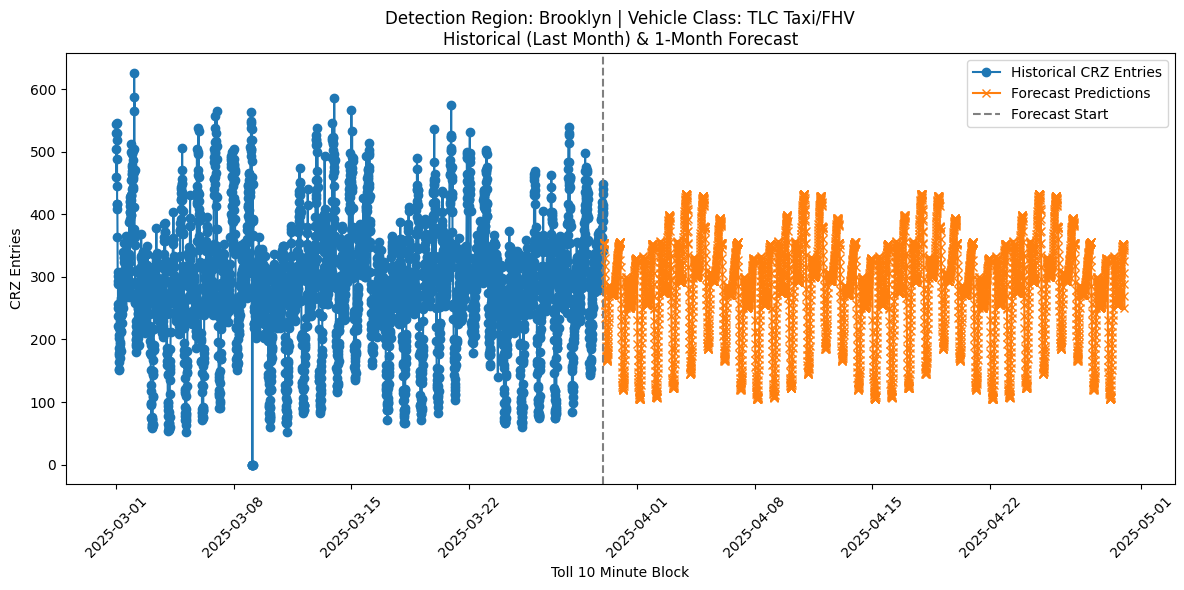

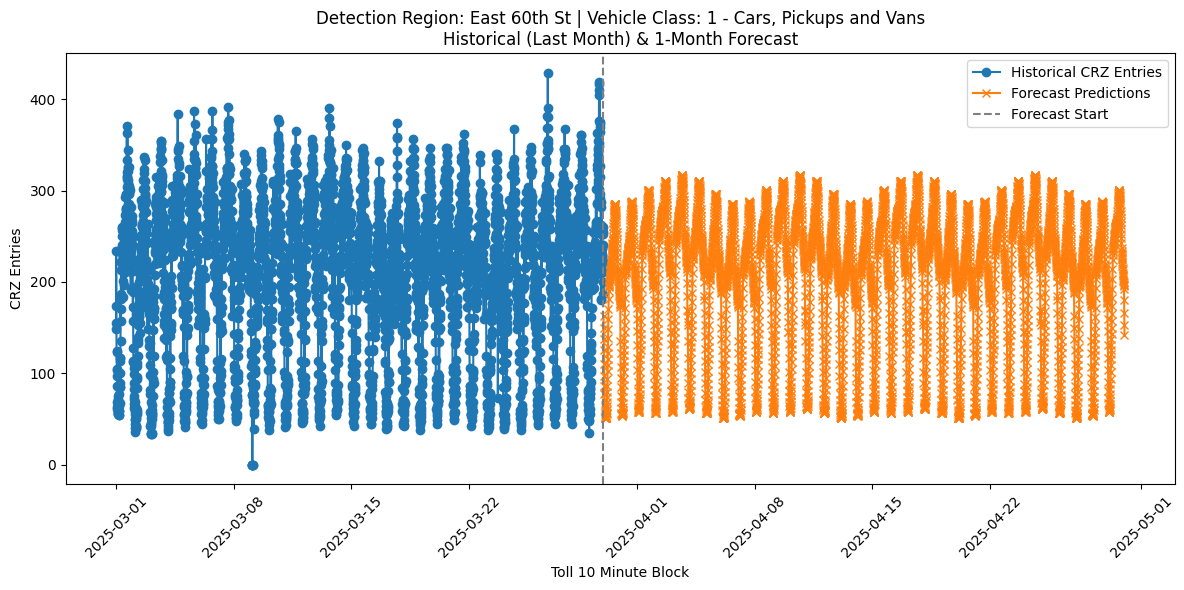

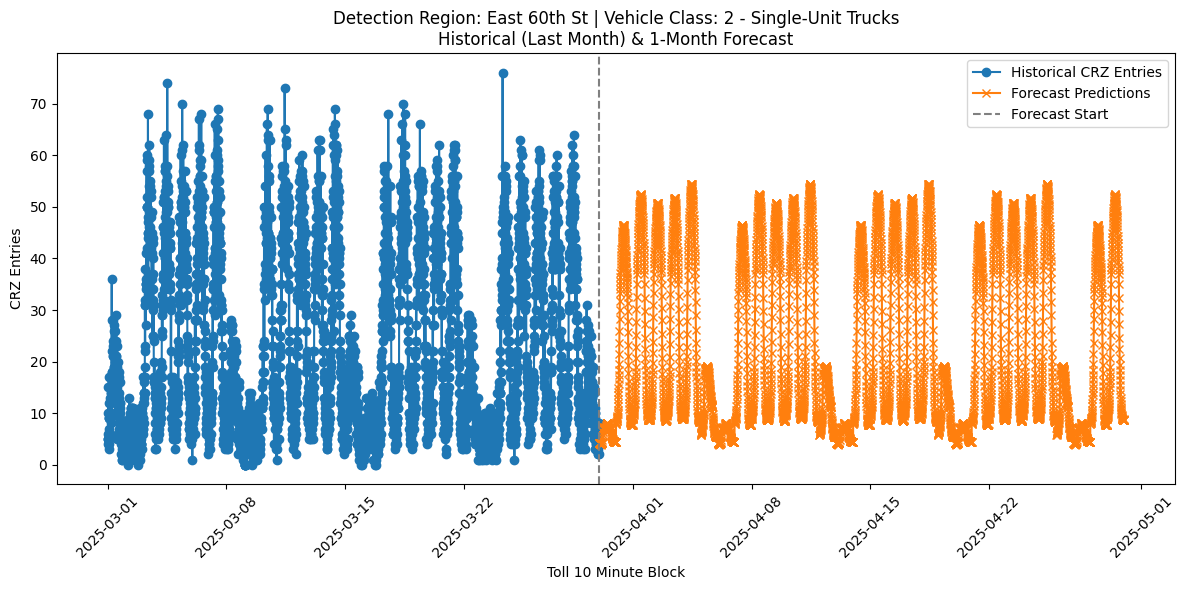

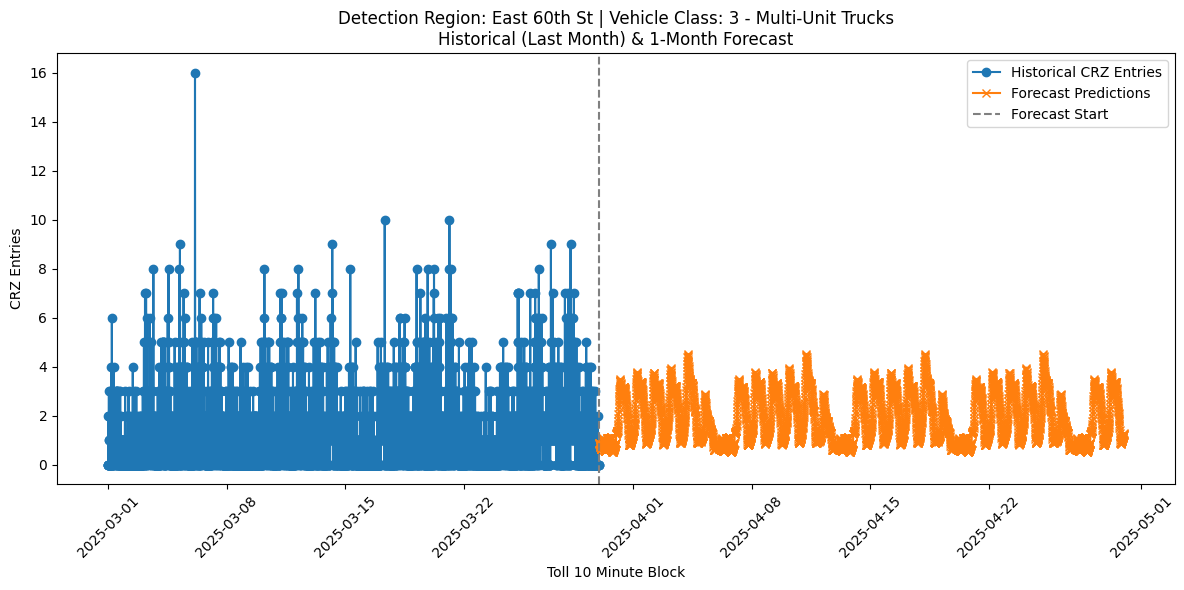

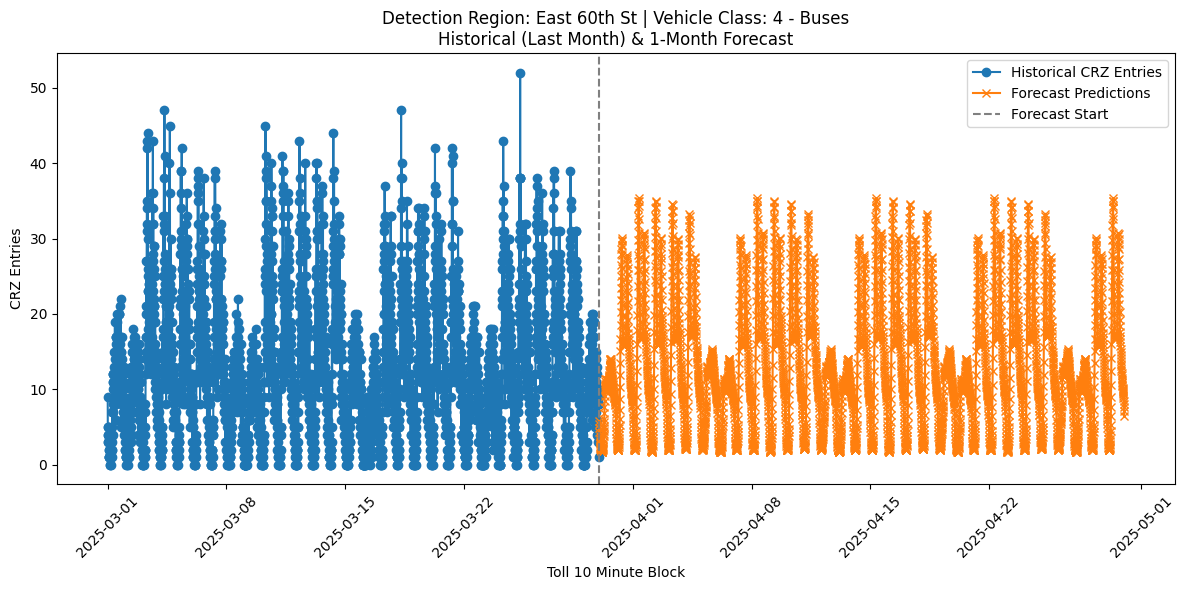

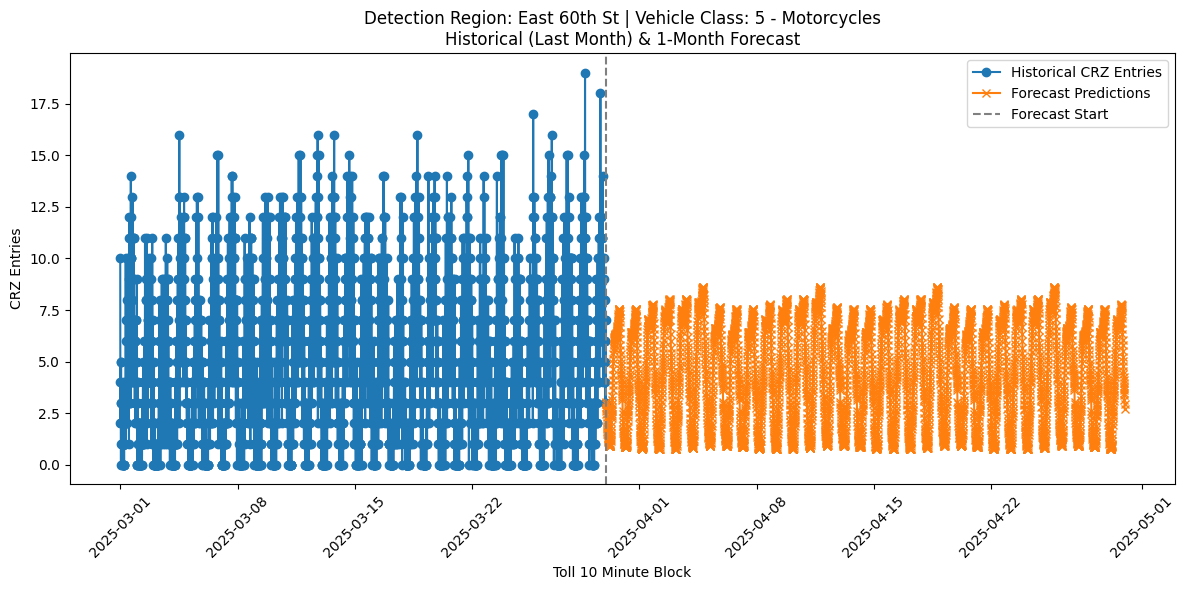

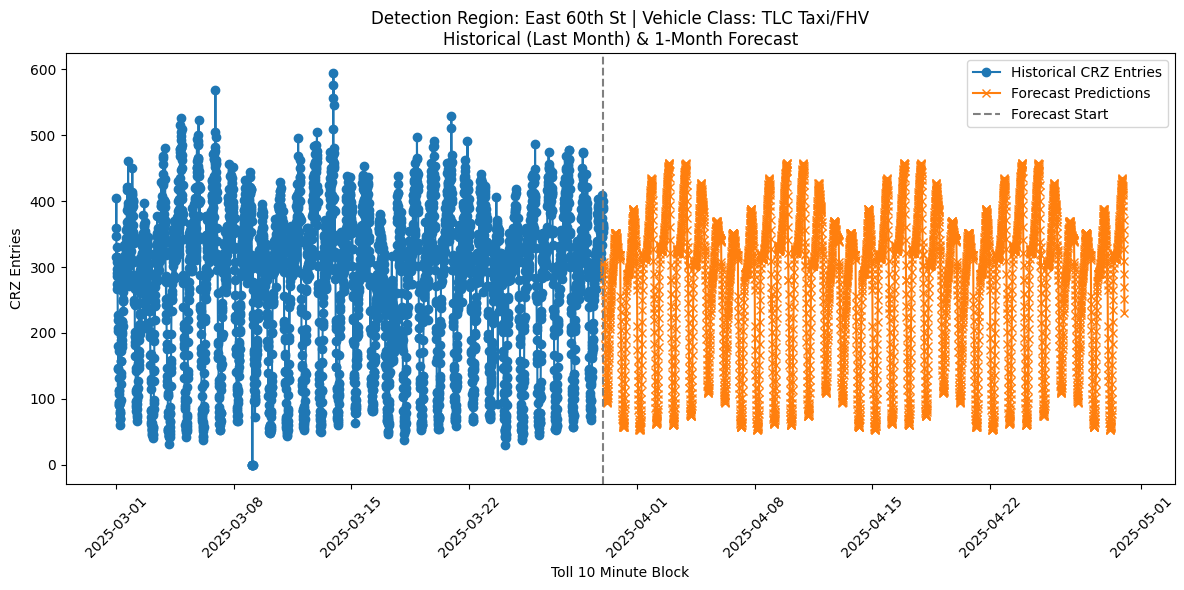

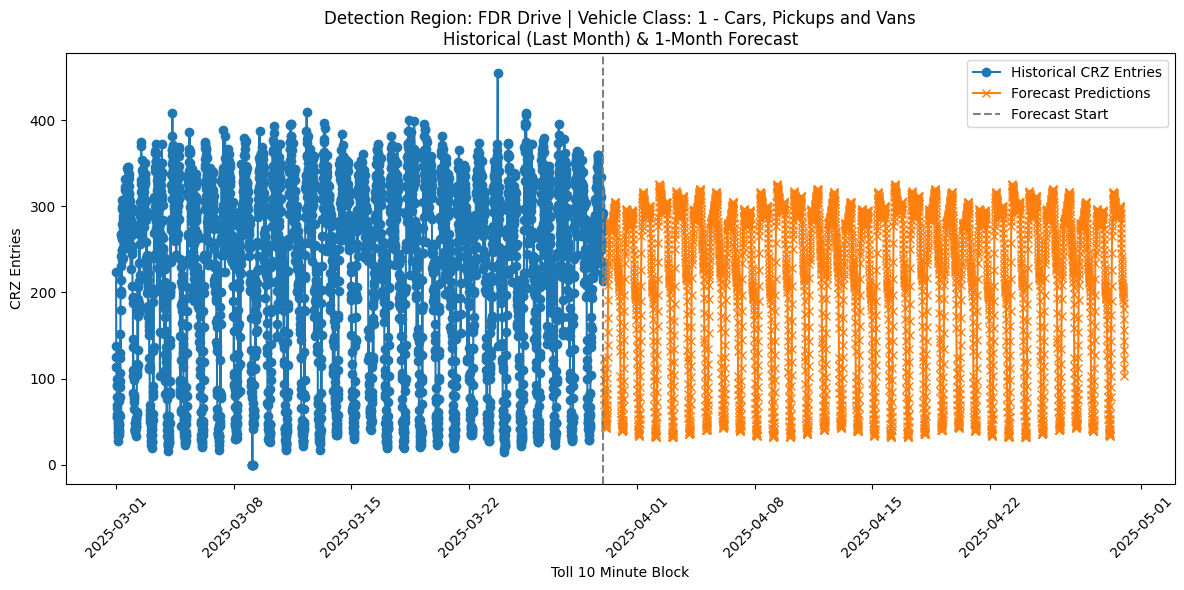

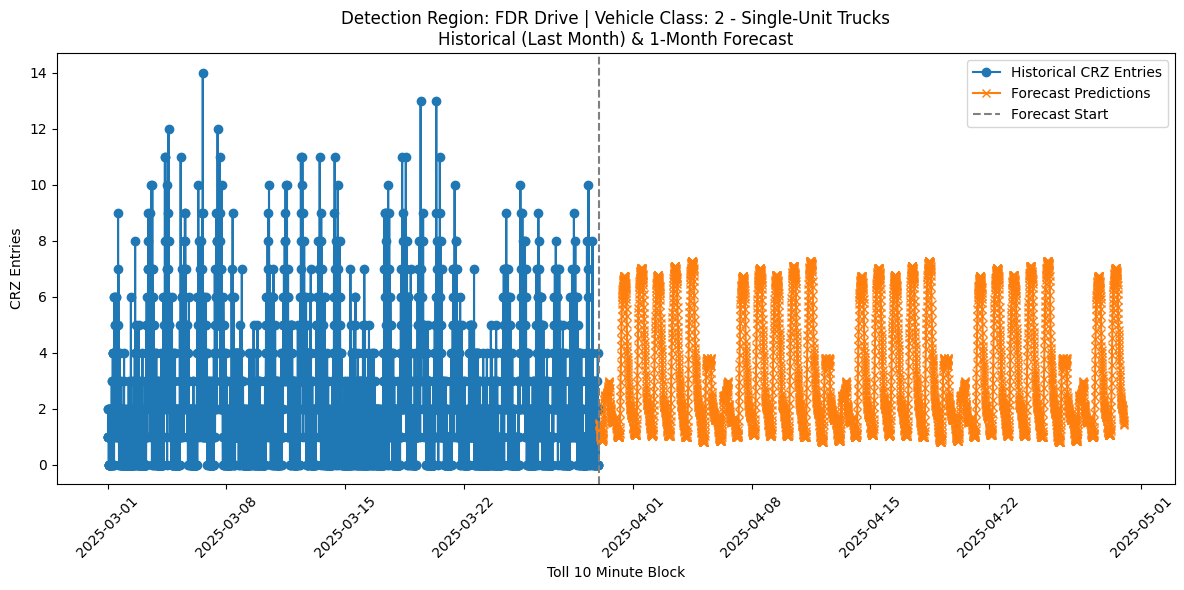

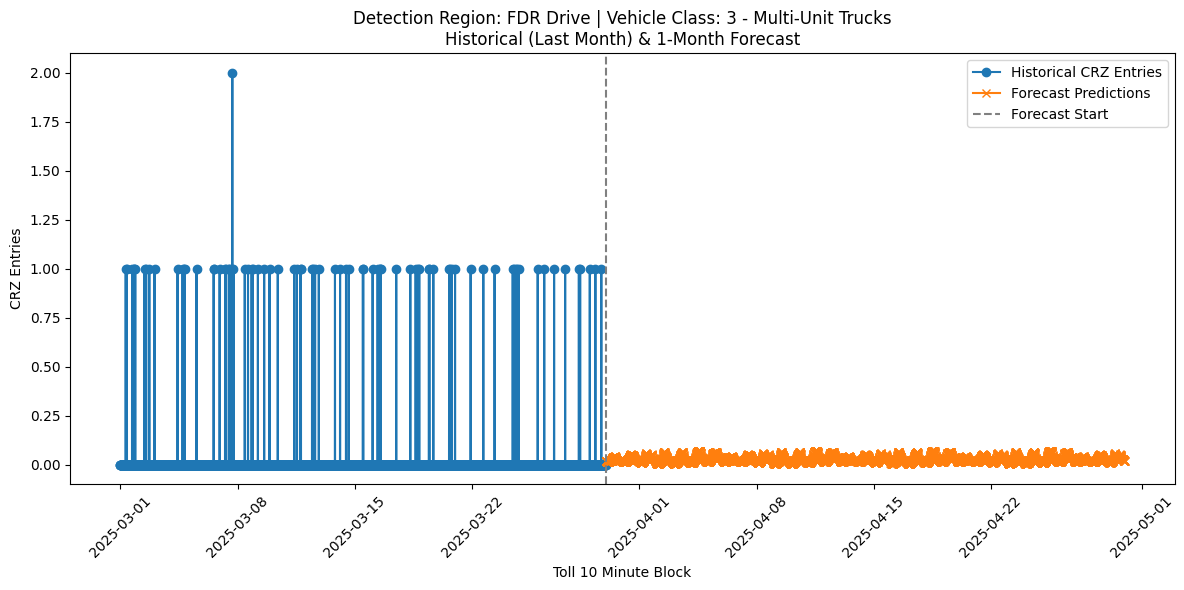

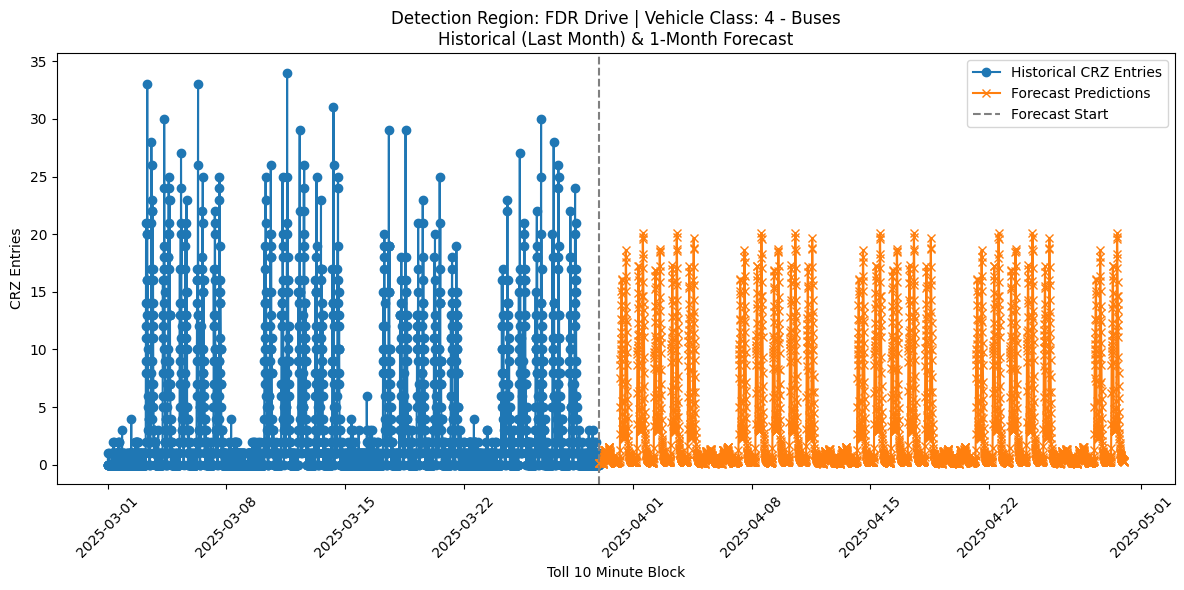

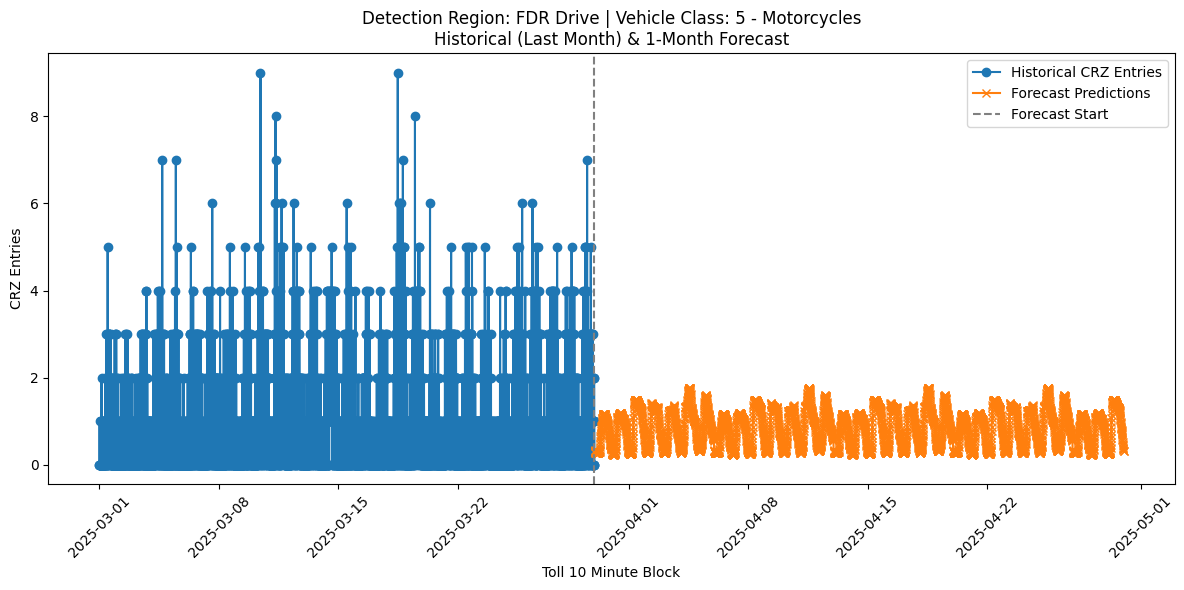

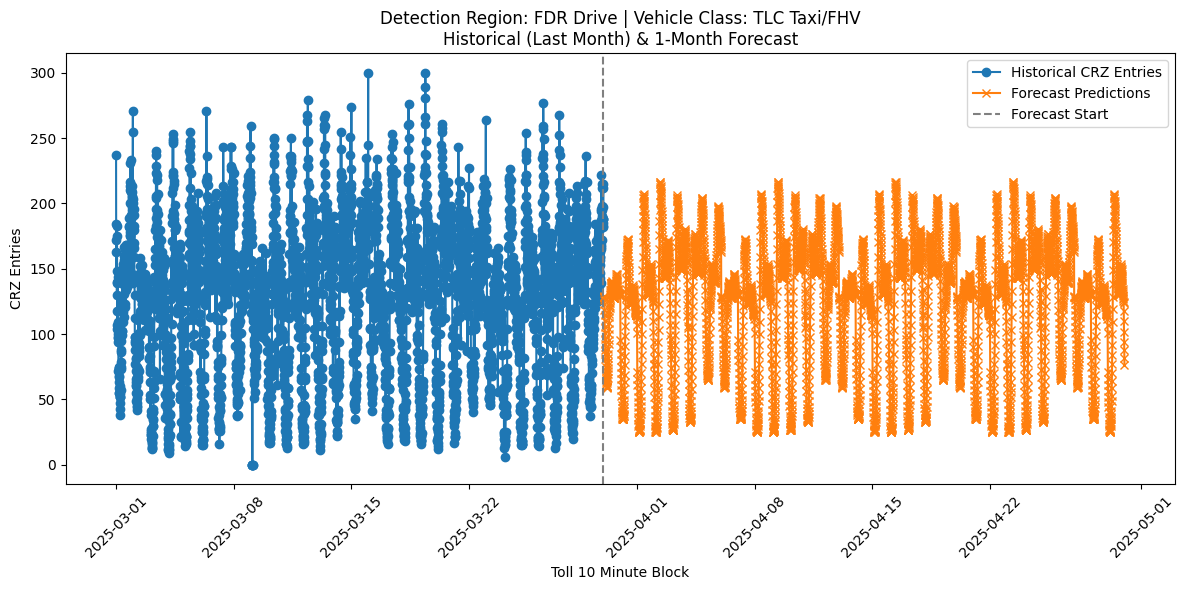

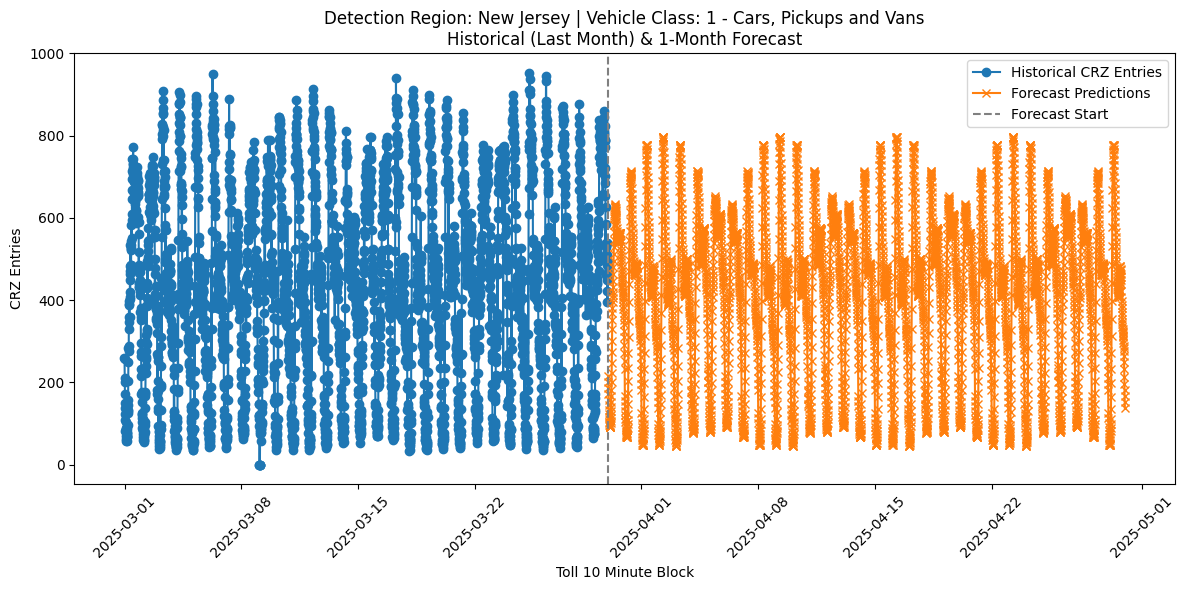

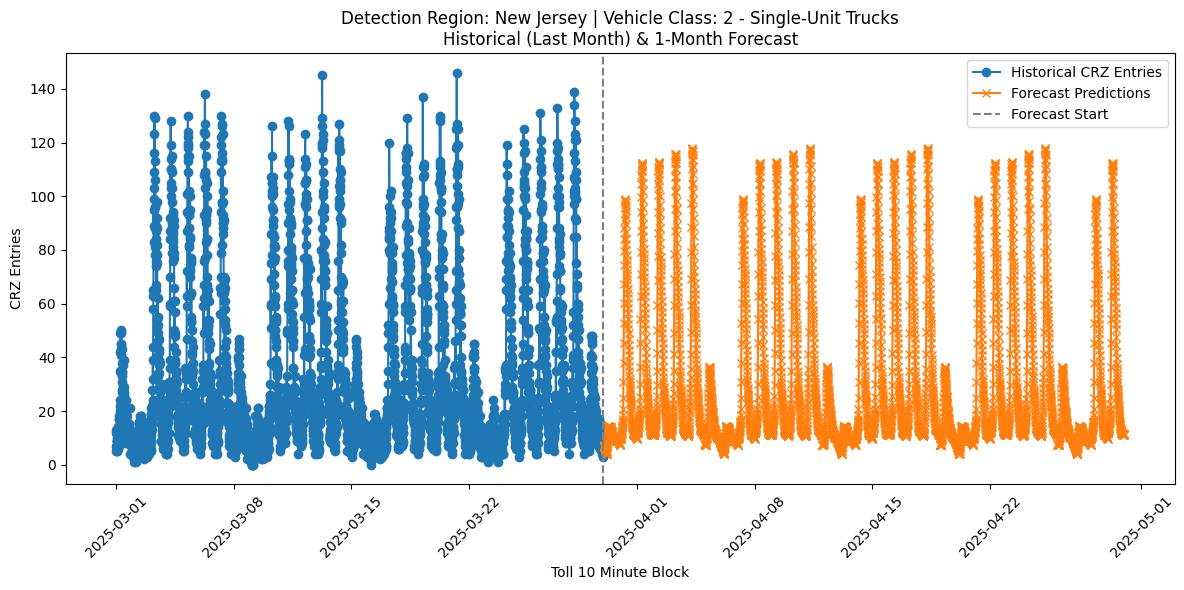

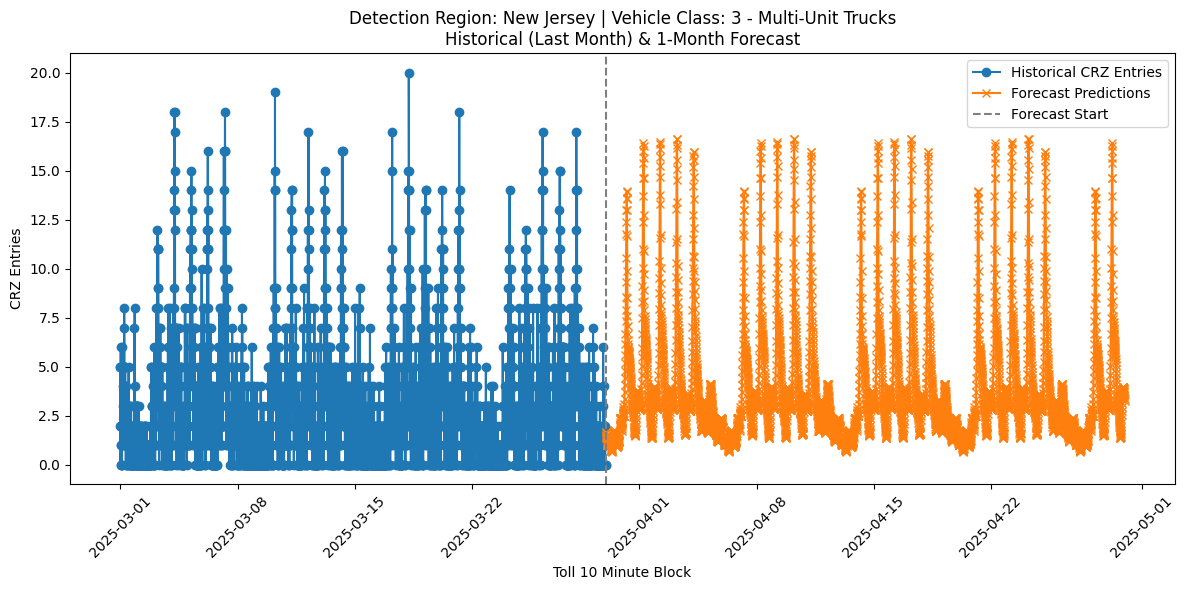

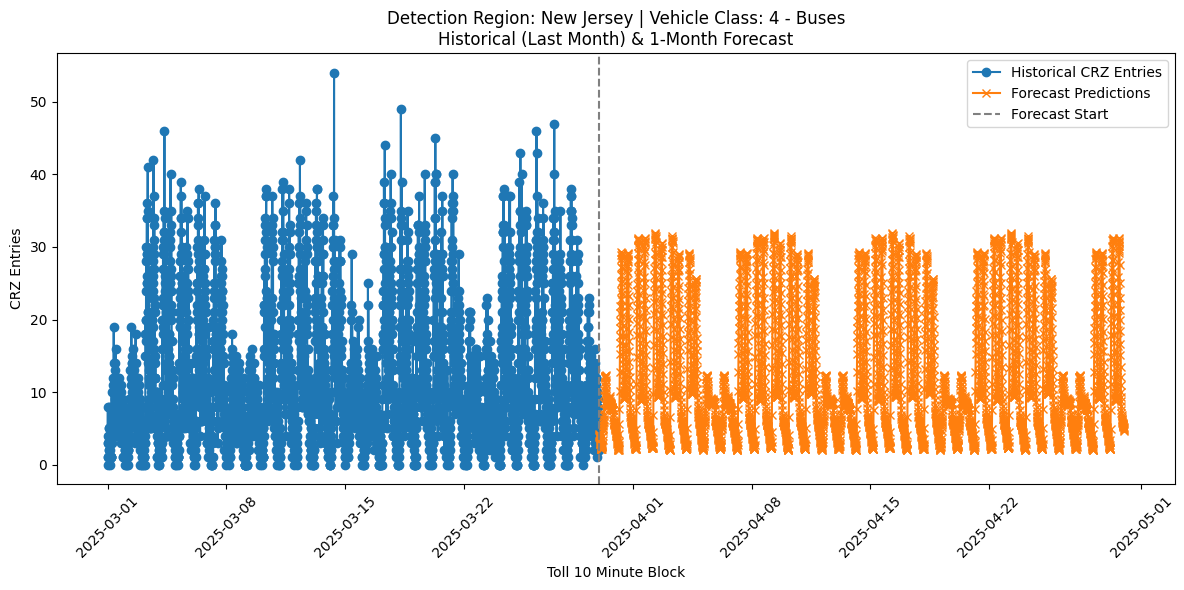

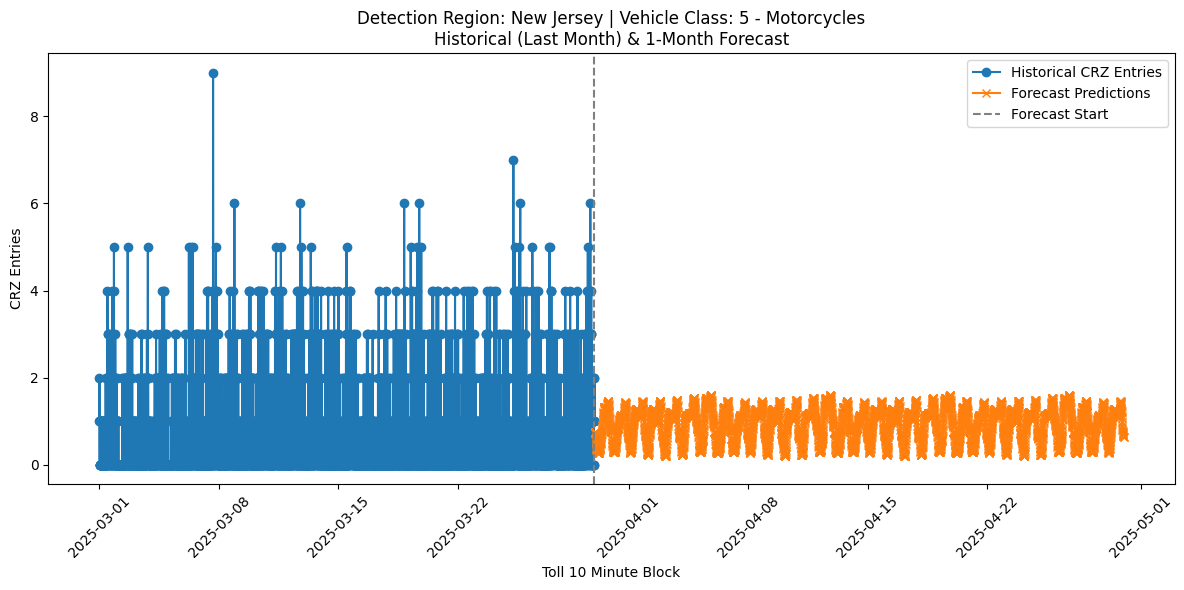

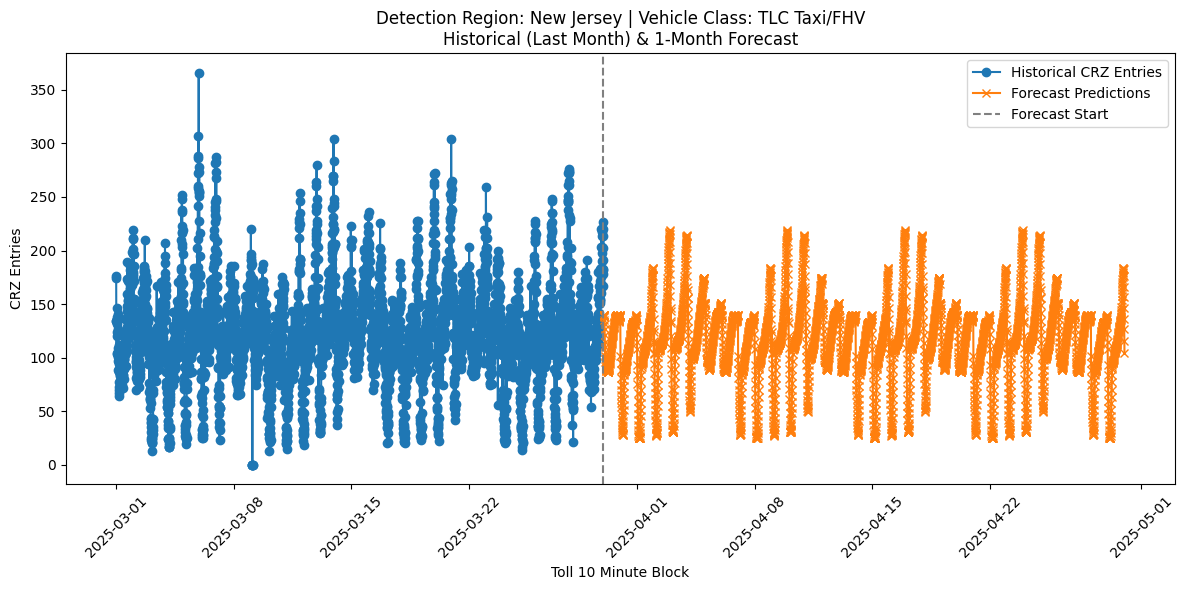

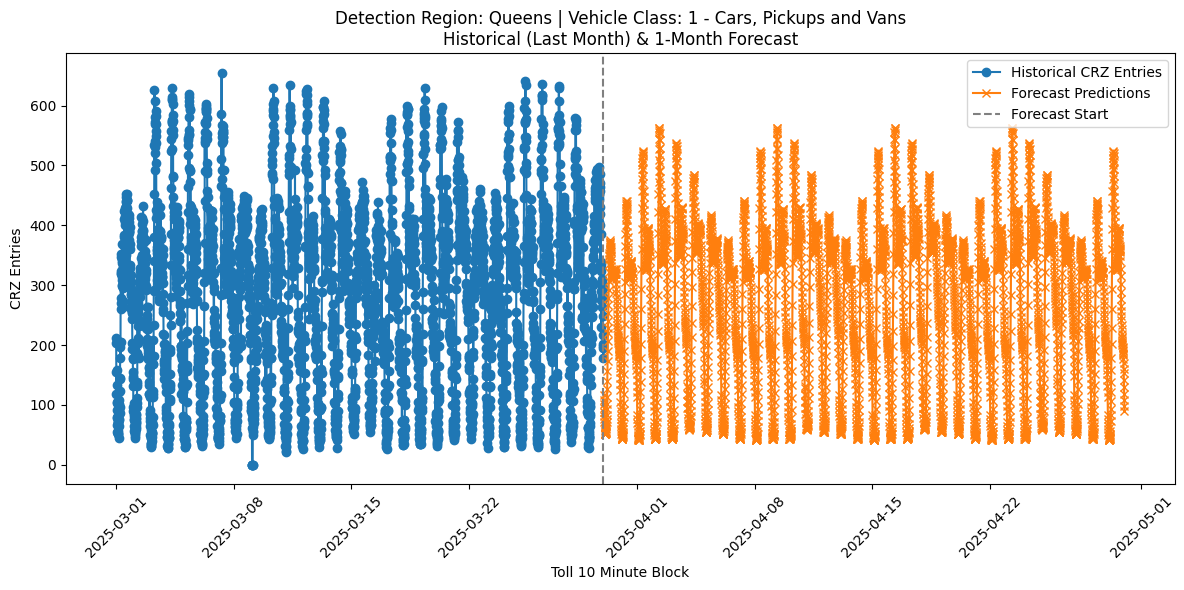

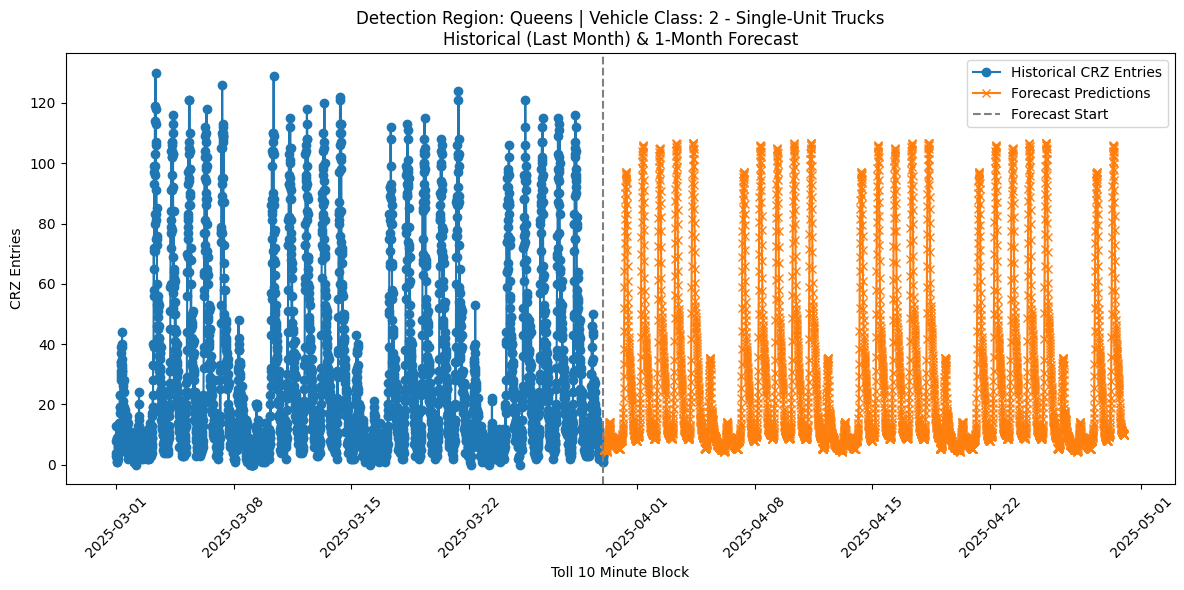

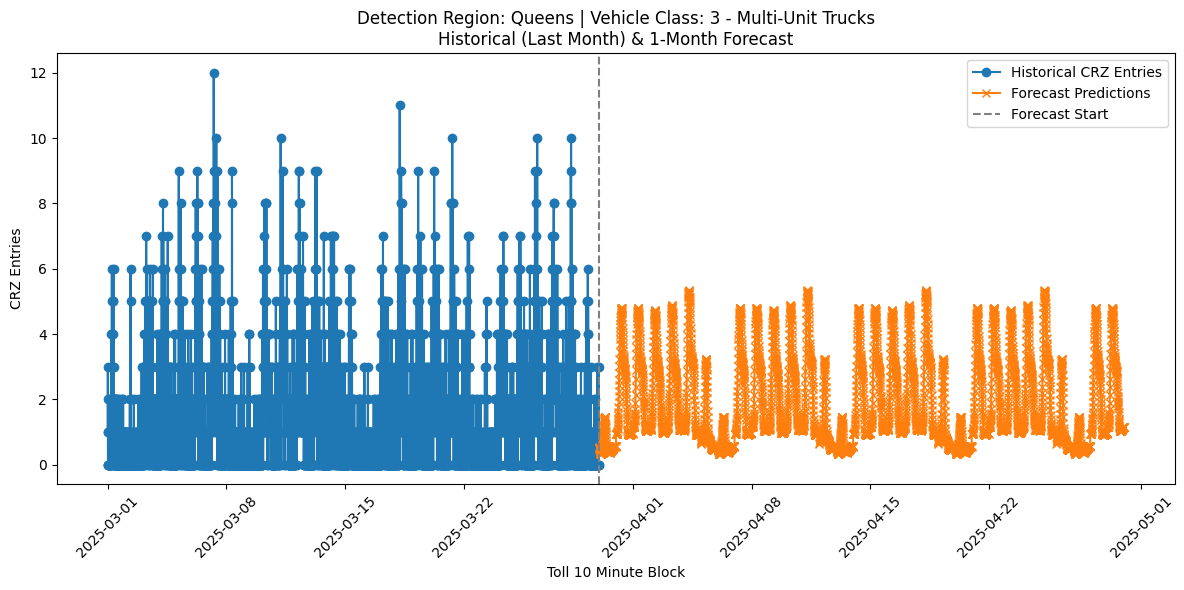

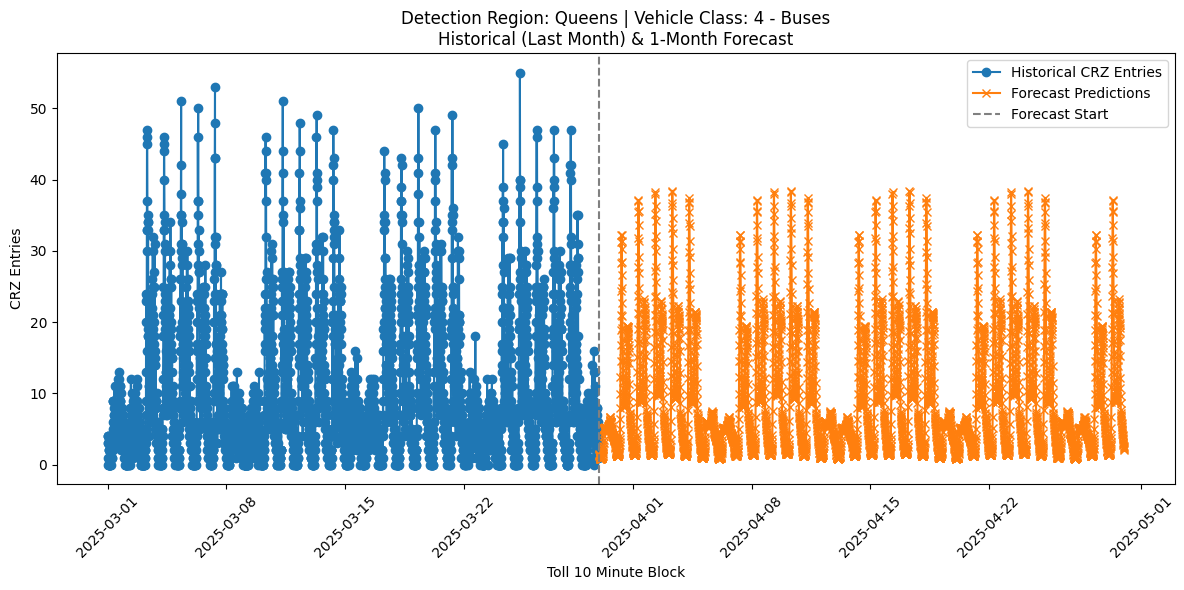

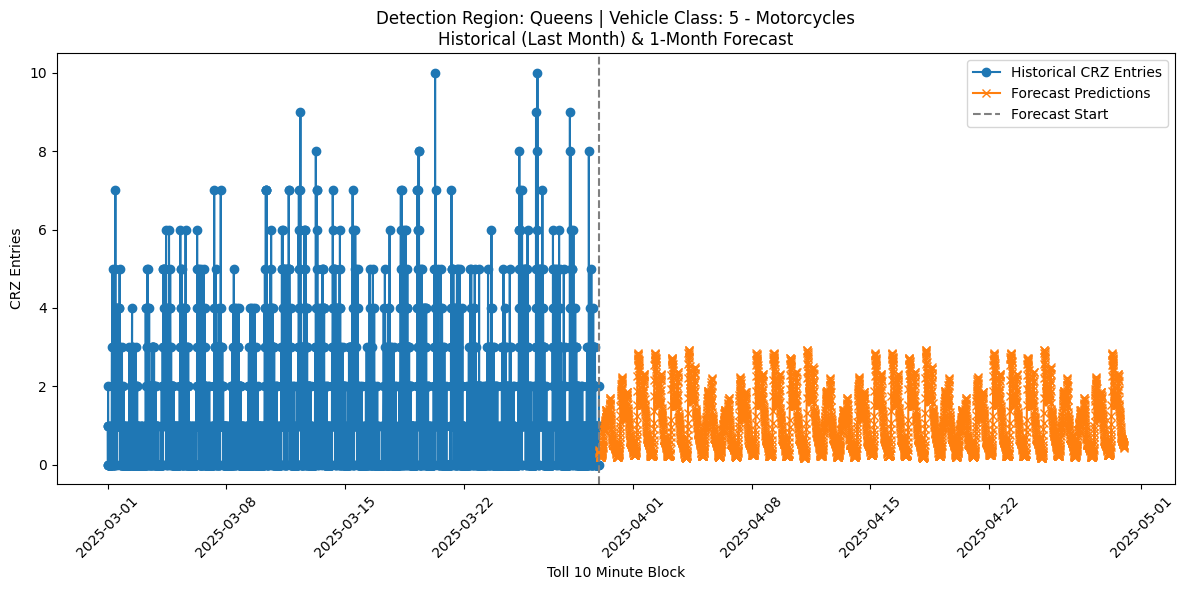

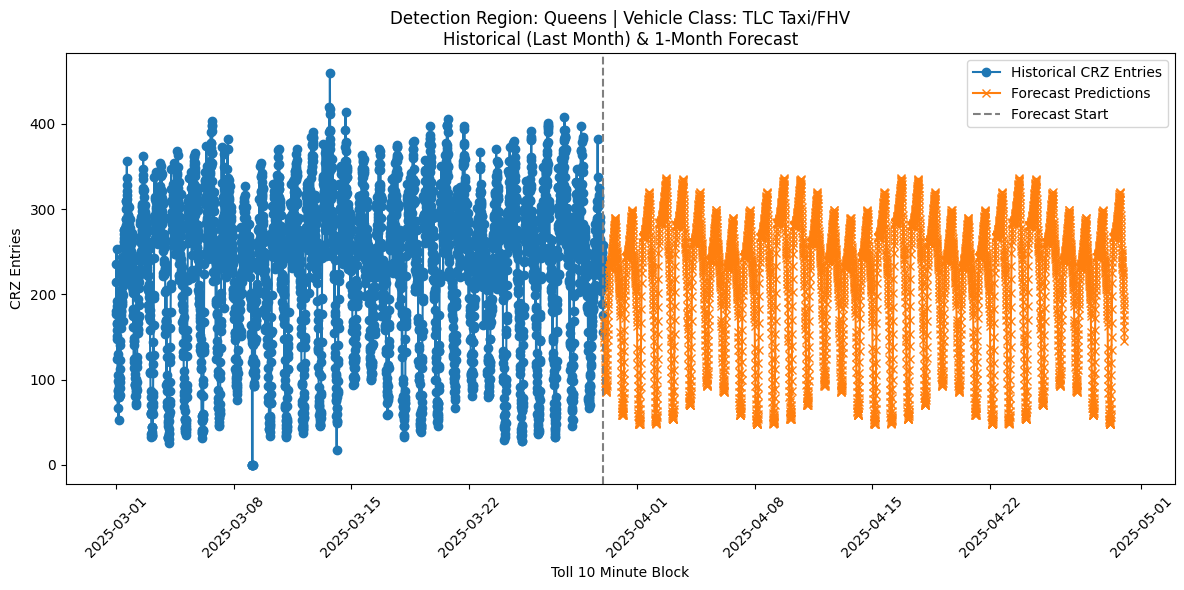

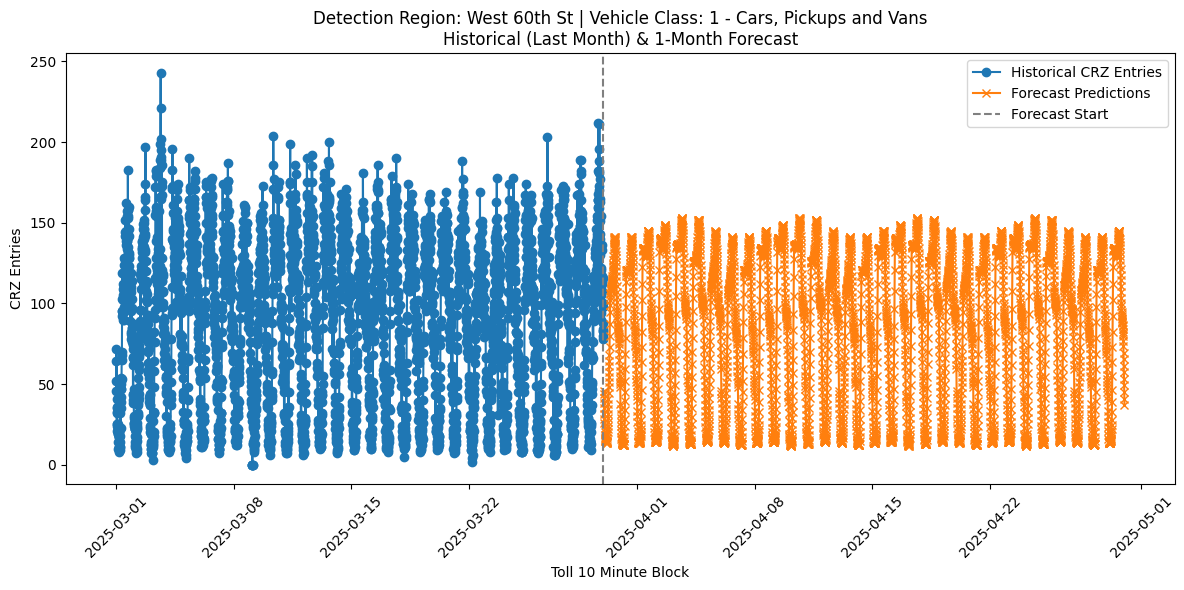

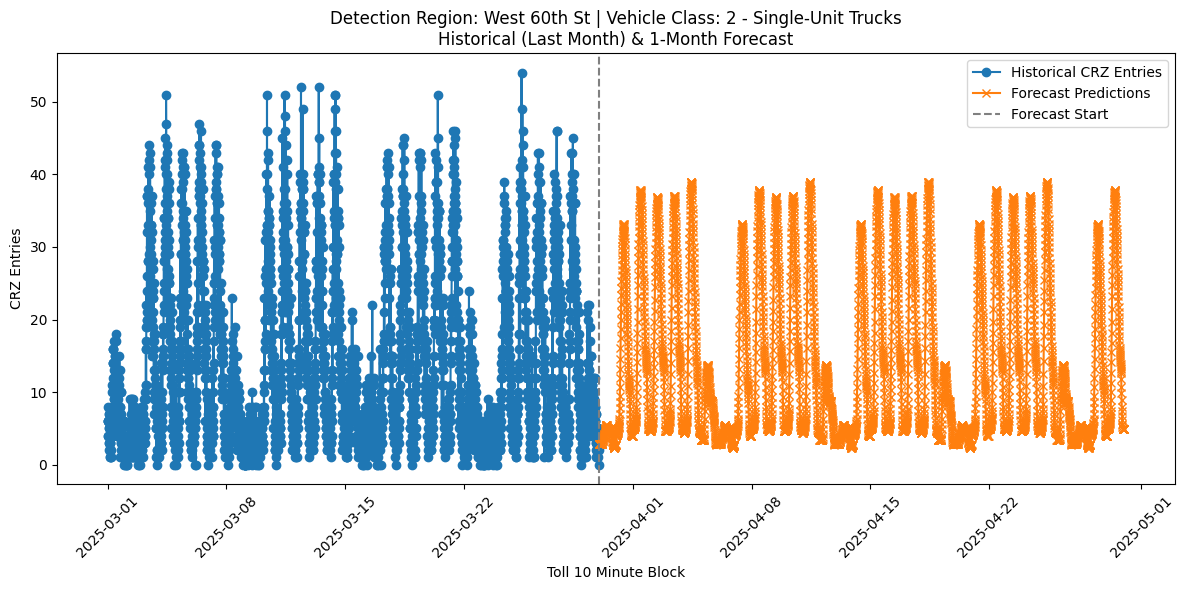

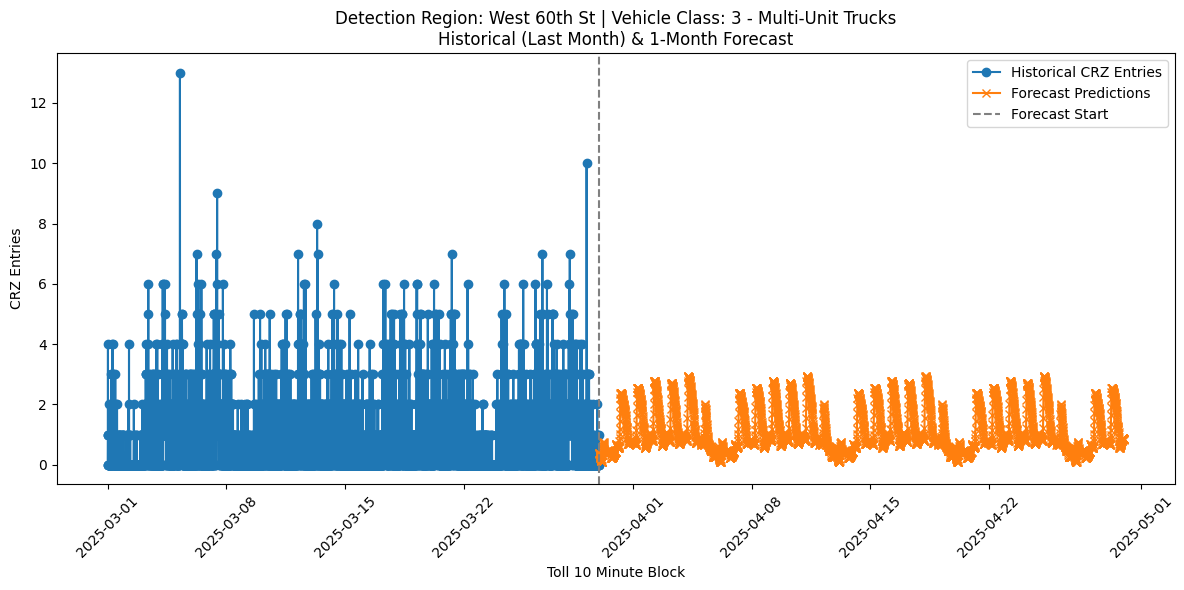

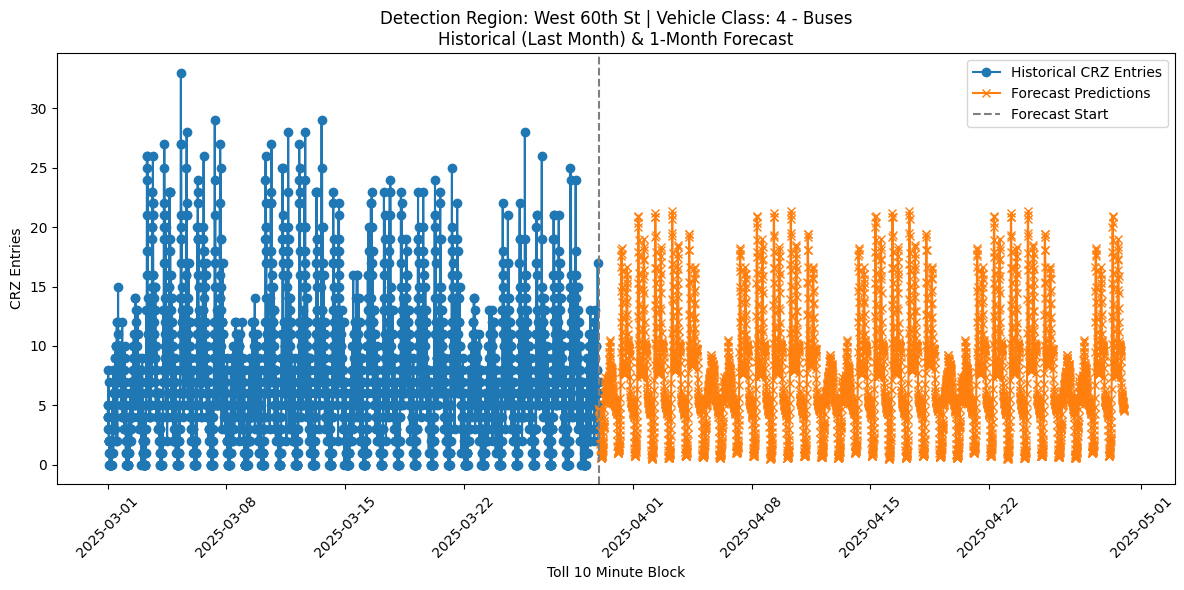

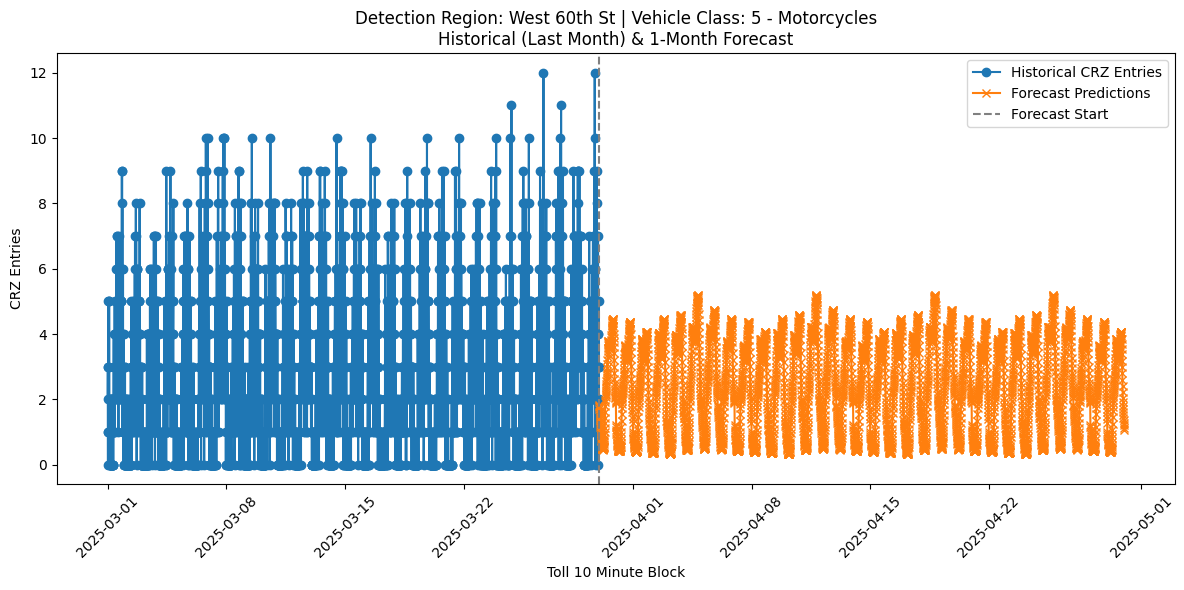

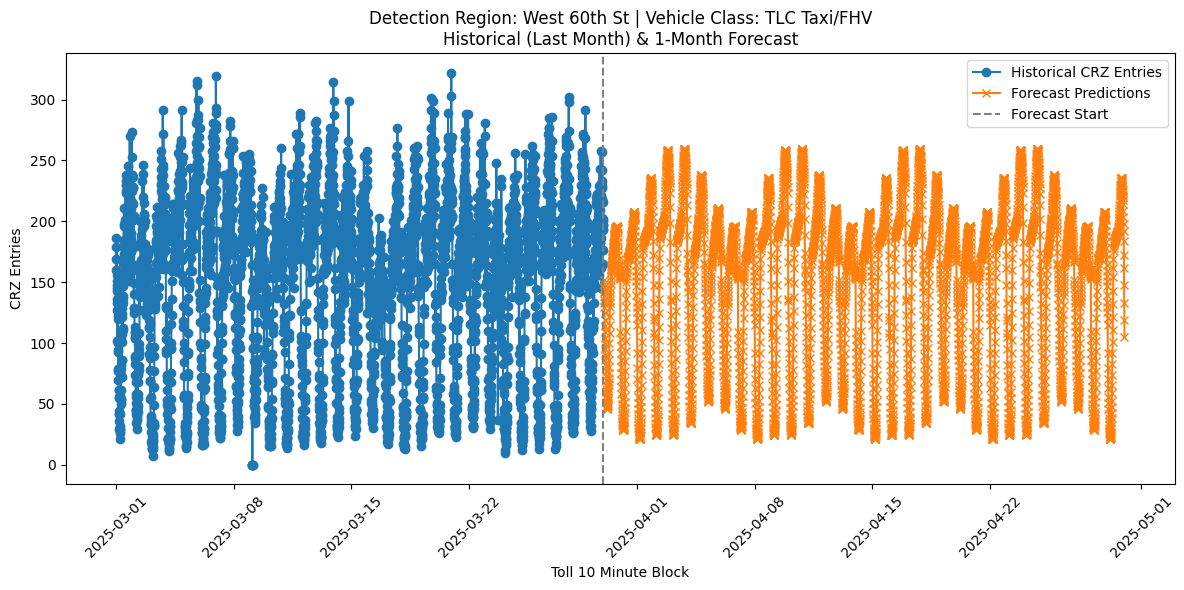

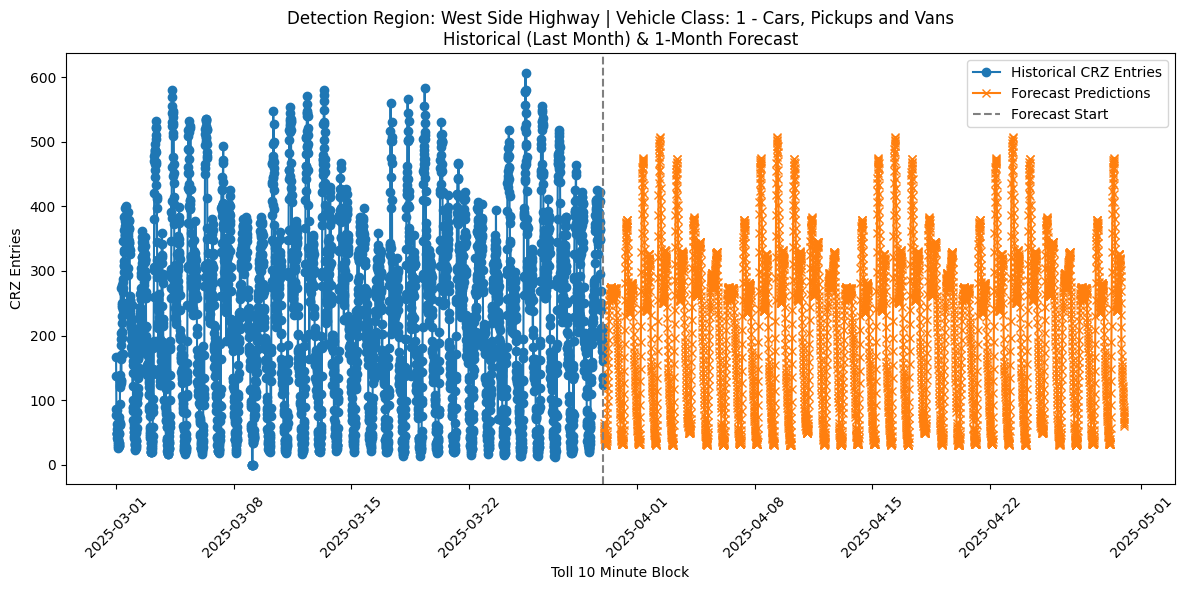

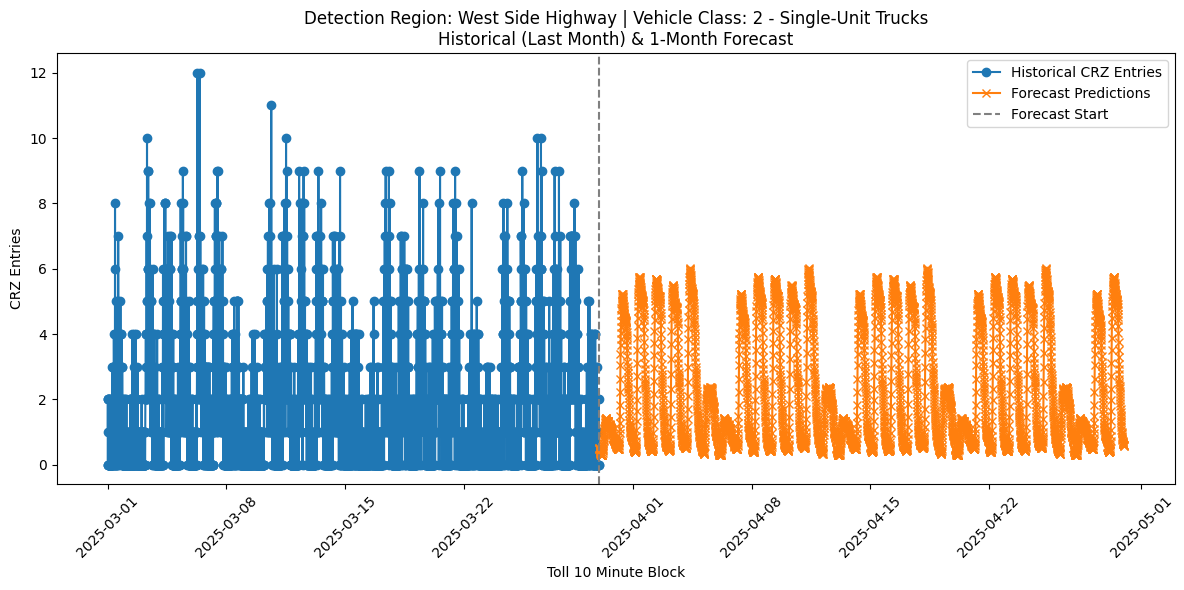

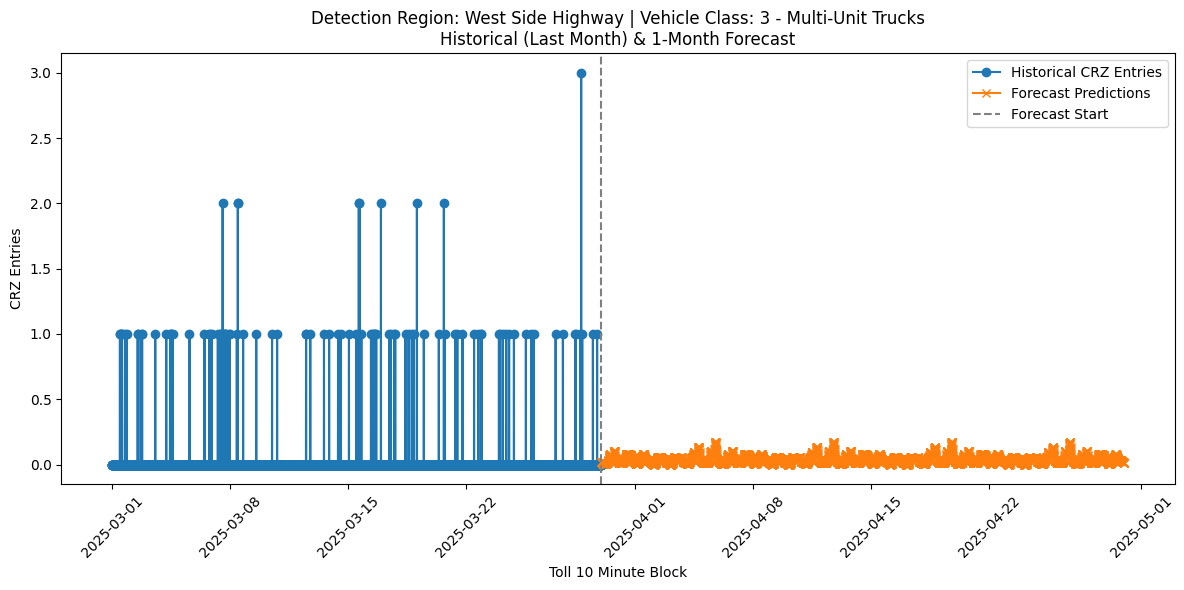

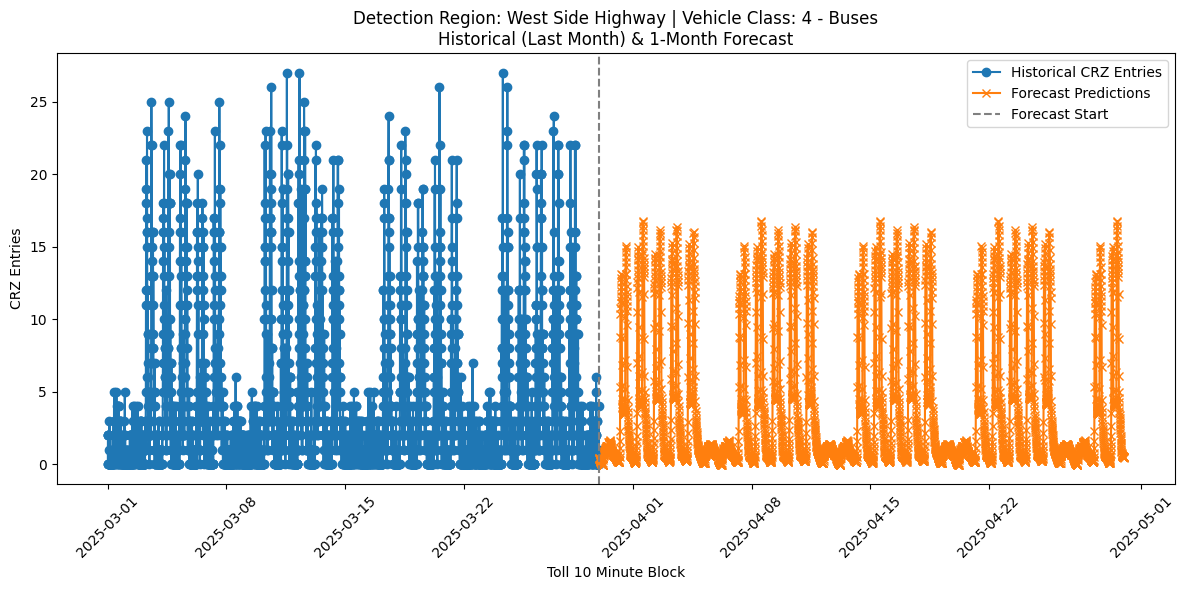

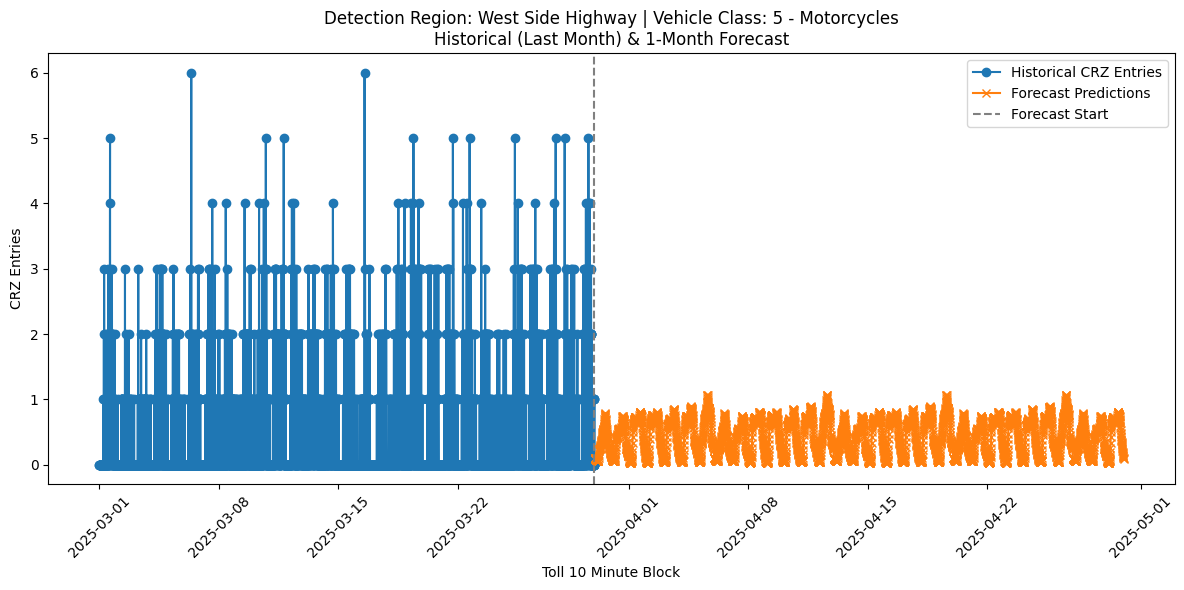

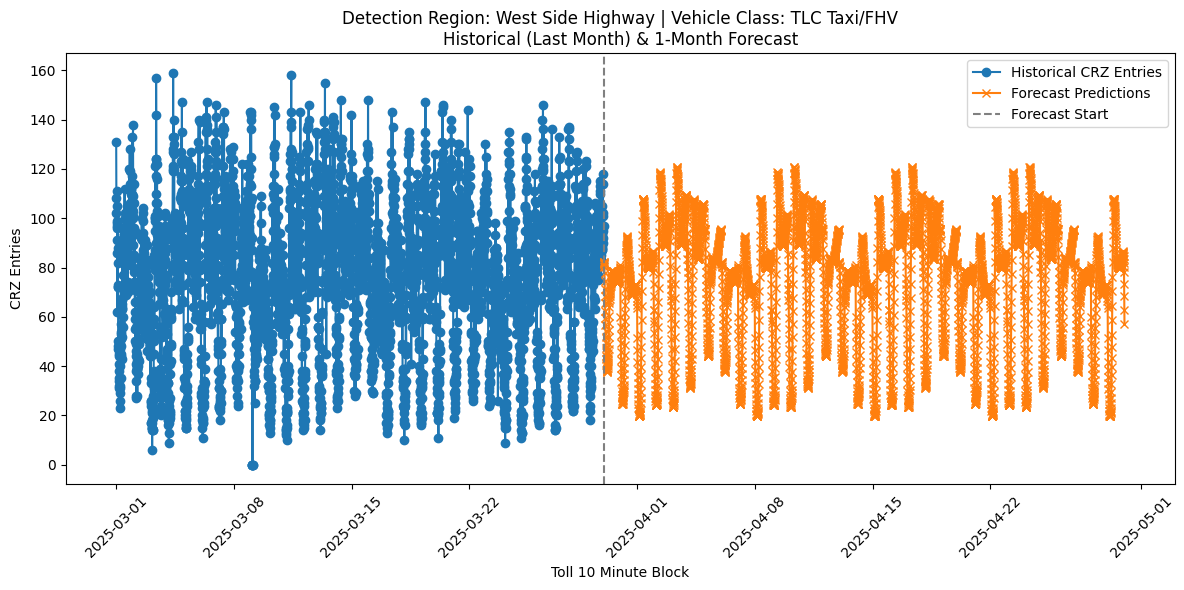

In [48]:
for region in df['Detection Region'].unique():
    df_region = df[df['Detection Region'] == region].copy()
    for vclass in df_region['Vehicle Class'].unique():
        df_group = df_region[df_region['Vehicle Class'] == vclass].copy()
        df_group.sort_values('Toll 10 Minute Block', inplace=True)
        if df_group.empty:
            continue
        
        # Get the last timestamp from the historical data.
        last_time = df_group['Toll 10 Minute Block'].max()
        # Define historical window as the last month.
        hist_start = last_time - pd.DateOffset(months=1)
        hist_data = df_group[df_group['Toll 10 Minute Block'] >= hist_start]
        
        # Get the forecast predictions for this group.
        forecast_data = all_future_preds_df[
            (all_future_preds_df['Detection Region'] == region) &
            (all_future_preds_df['Vehicle Class'] == vclass)
        ].copy()
        forecast_data.sort_values('Toll 10 Minute Block', inplace=True)
        
        # Plot historical and forecast data.
        plt.figure(figsize=(12, 6))
        plt.plot(hist_data['Toll 10 Minute Block'], hist_data['CRZ Entries'],
                 label='Historical CRZ Entries', marker='o')
        plt.plot(forecast_data['Toll 10 Minute Block'], forecast_data['Predicted CRZ Entries'],
                 label='Forecast Predictions', marker='x')
        plt.axvline(x=last_time, color='gray', linestyle='--', label='Forecast Start')
        plt.title(f"Detection Region: {region} | Vehicle Class: {vclass}\nHistorical (Last Month) & 1-Month Forecast")
        plt.xlabel('Toll 10 Minute Block')
        plt.ylabel('CRZ Entries')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()